In [3]:
%load_ext autotime
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

from IPython.core.display import clear_output

# noinspection PyUnresolvedReferences
import swifter

import itertools
import os
from pathlib import Path

from toolz import get
for folder in itertools.chain([Path.cwd()], Path.cwd().parents):
    if (folder / 'Pipfile').exists():
        os.chdir(folder)
        break

from notebooks.heart_transplant.dependencies.heart_transplant_data import get_reduced_binary_dataset_cached, \
    keep_only_heart, remove_last_year, reduce_dataset, get_binary_dataset_cached
from notebooks.heart_transplant.dependencies.heart_transplant_functions import  reverse_log_transform_dataset, extract_y_from_raw
from visualisation import display_number

from matplotlib import pyplot as plt


/home/sitnarf/projects/cardiovascular-risk-app/backend
time: 19.6 ms (started: 2021-03-24 01:55:16 +01:00)


In [4]:
X_365, y_365, dataset_raw = get_reduced_binary_dataset_cached()

X_365_full, y_365_full, _ = get_binary_dataset_cached()

X_90, y_90, _ = get_reduced_binary_dataset_cached(survival_days=90)

root:WARNING: [MemorizedFunc(func=<function get_reduced_binary_dataset at 0x7f476c874e50>, location=./temporary/cache_1/joblib)]: Clearing function cache identified by notebooks/heart_transplant/dependencies/heart_transplant_data/get_reduced_binary_dataset
/home/sitnarf/.local/share/virtualenvs/backend-g-pApWmb/lib/python3.8/site-packages/joblib/memory.py:761: DtypeWarning: Columns (127) have mixed types.Specify dtype option on import or set low_memory=False.
  output = self.func(*args, **kwargs)
root:WARNING: [MemorizedFunc(func=<function get_binary_dataset at 0x7f476c874dc0>, location=./temporary/cache_1/joblib)]: Clearing function cache identified by notebooks/heart_transplant/dependencies/heart_transplant_data/get_binary_dataset


________________________________________________________________________________
[Memory] Calling notebooks.heart_transplant.dependencies.heart_transplant_data.get_reduced_binary_dataset...
get_reduced_binary_dataset()
___________________________________get_reduced_binary_dataset - 1236.5s, 20.6min
________________________________________________________________________________
[Memory] Calling notebooks.heart_transplant.dependencies.heart_transplant_data.get_binary_dataset...
get_binary_dataset()
time: 34min 55s (started: 2021-03-24 01:55:16 +01:00)


Pandas Apply:   0%|          | 0/86620 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/86620 [00:00<?, ?it/s]

KeyboardInterrupt: 

## Exploratory analysis

### Total rows (dataset_raw)

In [ ]:
display_number(len(dataset_raw))

### Total rows (transplantation has occurred)

In [24]:
X_total = dataset_raw[~dataset_raw['death'].isna()]

display_number(len(X_total))

time: 110 ms (started: 2021-03-23 15:23:18 +01:00)


### Total rows (only heart transplantation)

In [ ]:
X_only_heart = keep_only_heart(X_total)
display_number(len(X_only_heart))

### Total rows (year 2017 removed)

In [ ]:
X_only_heart = remove_last_year(X_only_heart)
display_number(len(X_only_heart))


### Outcome missing

In [ ]:
X_outcome_defined = X_only_heart[~X_only_heart['futd'].isna()]
display_number(len(X_outcome_defined))


### Total rows (only with > 80 non-missing variables kept)


In [27]:
from functional import pipe
from functools import partial

X_reduced = pipe(
    X_only_heart,
    partial(reduce_dataset, y=y_365),
    partial(get, 0),
)

display_number(len(X_reduced))

time: 3.94 s (started: 2021-03-23 15:23:24 +01:00)


### Total rows (label for 365 days not defined)

$death = 0$ and $futd \leq 365$

In [29]:
import numpy as np

X_reduced_outcome_present = X_reduced[~ np.isnan(X_reduced['death'])]

X_reduced_outcome_present_y = extract_y_from_raw(X_reduced_outcome_present)

clear_output()

display_number(X_reduced_outcome_present_y.isna().sum())

display_number(len(X_reduced[np.isnan(X_reduced['death'])]))


time: 1.27 s (started: 2021-03-23 15:25:49 +01:00)


In [32]:
X_reduced_outcome_present[~ X_reduced_outcome_present_y.isna()]

,thoracic_dgn,gender,abo,wgt_kg_tcr,hgt_cm_tcr,iabp_tcr,inotropes_tcr,func_stat_tcr,diab,cereb_vasc,...,newlbmratio,dcmass,rcmass,cmassratio,sexmatch,anyecmo,pvr,anyvent,tx_date,admission_date
0,1203.0,M,A,30.0000,132.00,0,0,996.0,NaN,NaN,...,1.000000,101.12160,94.523361,1.069805,MM,0,NaN,0,23-Apr-92,NaN
2,1002.0,F,O,69.2181,170.18,0,1,2020.0,1.0,N,...,1.209200,183.02489,146.439210,1.249835,FM,0,0.357143,0,12-Apr-08,4-Feb-08
3,1000.0,M,B,101.6050,177.80,0,0,1.0,1.0,N,...,1.000000,235.25696,214.089940,1.098870,MM,0,5.744681,0,13-May-05,18-Apr-05
4,1999.0,M,A,71.2140,170.18,0,0,2.0,1.0,U,...,NaN,NaN,171.120210,NaN,MM,0,NaN,0,2-Oct-92,NaN
5,1007.0,M,A,71.6680,167.64,0,0,2070.0,1.0,N,...,0.837504,151.85977,166.644300,0.911281,MF,0,2.142857,0,1-Nov-08,26-Oct-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153203,1000.0,F,A,89.3600,173.00,0,0,1.0,1.0,N,...,1.000000,133.49529,165.016540,0.808981,FF,0,2.272727,0,18-Sep-99,18-Sep-99
153204,1007.0,F,A,86.7000,162.56,0,0,1.0,5.0,N,...,1.000000,119.09061,155.915330,0.763816,FF,0,0.476190,0,1-May-00,1-May-00
153205,1999.0,M,A,96.0000,185.00,0,0,998.0,NaN,NaN,...,1.000000,204.98816,212.502140,0.964640,MM,0,NaN,0,23-Oct-91,NaN
153206,1007.0,M,O,87.0000,170.18,0,1,996.0,1.0,N,...,1.000000,168.01576,189.032620,0.888819,MM,0,-2.222222,0,23-Aug-04,4-Aug-04


time: 124 ms (started: 2021-03-23 17:34:37 +01:00)


### Column with $\geq 80\%$ missing values

In [5]:
for column_name, series in X_365.items():
     if series.isna().sum()/len(series) >= 0.8:
         print(column_name, series.isna().sum()/len(series))

contin_cocaine_don 0.9185163379452458
time: 207 ms (started: 2021-03-23 14:46:44 +01:00)


### Total rows with 365 days survival defined

In [10]:
display_number(len(X_365))

time: 39.7 ms (started: 2021-03-23 14:12:39 +01:00)


### Total rows with 90 days survival defined

In [11]:
display_number(len(X_90))

time: 12.7 ms (started: 2021-03-23 14:12:39 +01:00)


### Number of available variable per row histogram (dataset_raw)

In [ ]:
dataset_raw.swifter.apply(lambda x: x.count(), axis=1).hist();

### Number of available variables per row histogram (final all age groups)

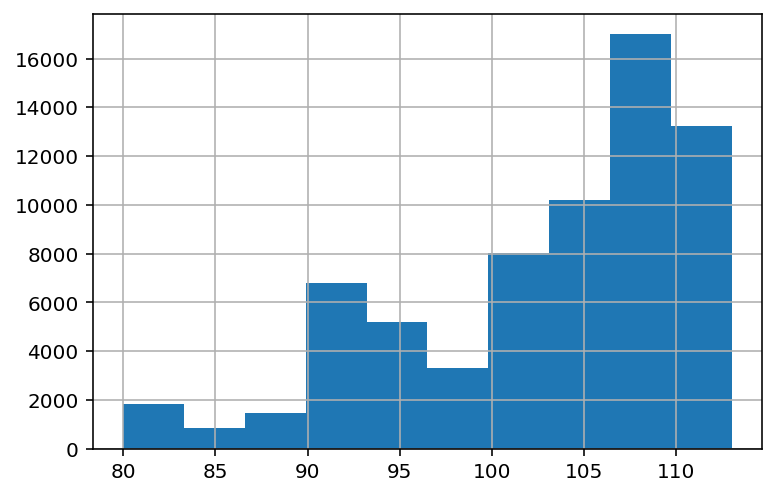

time: 1.18 s (started: 2021-03-23 14:12:42 +01:00)


In [13]:
X_365.swifter.apply(lambda x: x.count(), axis=1).hist();


### Total input features after preprocessing

Note: additional variables might be automatically removed during training due to 0 variance

In [14]:
display_number(len(X_365.columns))

time: 12.9 ms (started: 2021-03-23 14:12:43 +01:00)


## Class balance

### 365 days survival

In [15]:
y_365.value_counts()

0    59546
1     8394
dtype: int64

time: 14.7 ms (started: 2021-03-23 14:12:43 +01:00)


### 90 days survival

In [16]:
y_90.value_counts()

0    65343
1     5501
dtype: int64

time: 15.2 ms (started: 2021-03-23 14:12:43 +01:00)


## Death-year relation


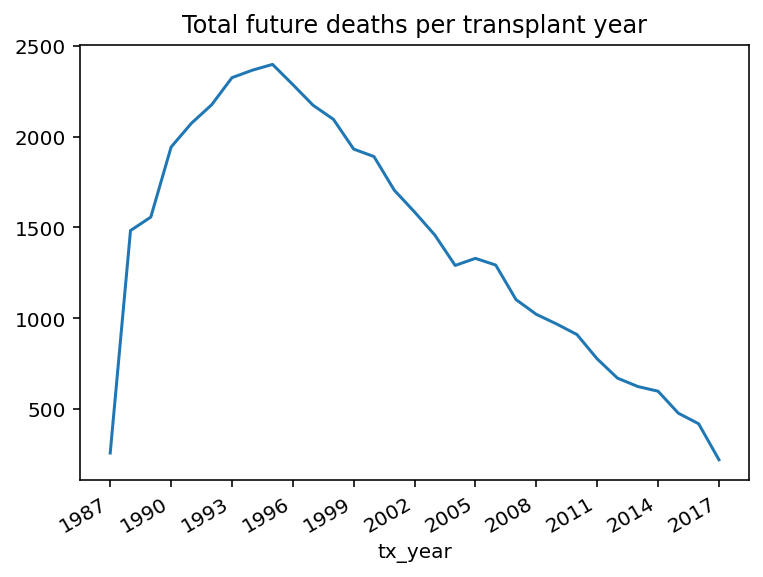

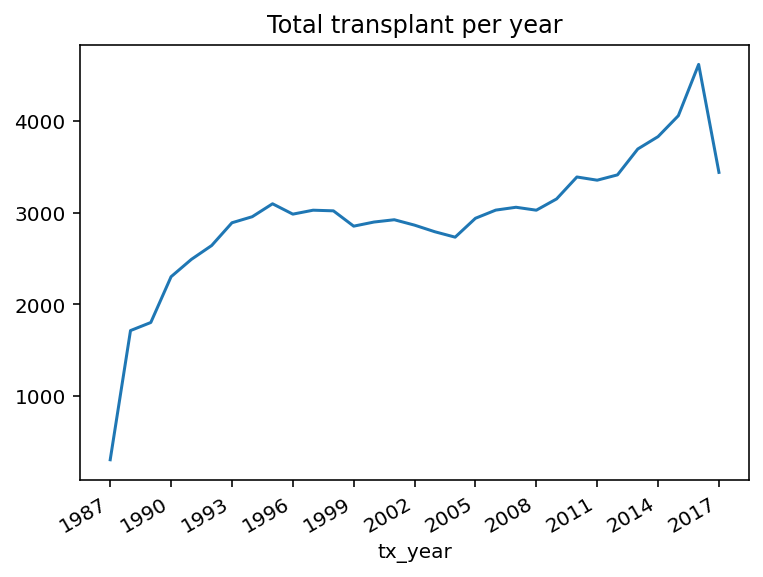

time: 248 ms (started: 2021-03-23 14:12:43 +01:00)


In [17]:
from matplotlib import pyplot

def set_x_ticks():
    plt.xticks([
        *range(int(dataset_raw['tx_year'].min()), int(dataset_raw['tx_year'].max()), 3),
        int(dataset_raw['tx_year'].max())
    ])


pyplot.title('Total future deaths per transplant year')
dataset_raw['death'].groupby(dataset_raw['tx_year']).sum().plot()
pyplot.setp(pyplot.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
set_x_ticks()
pyplot.show()

pyplot.title('Total transplant per year')
dataset_raw['death'].groupby(dataset_raw['tx_year']).count().plot()
pyplot.setp(pyplot.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks([*range(int(dataset_raw['tx_year'].min()), int(dataset_raw['tx_year'].max()), 3),
            int(dataset_raw['tx_year'].max())])

pyplot.show()

In [18]:
len(dataset_raw[dataset_raw['tx_year'].isna()])


61862

time: 65.3 ms (started: 2021-03-23 14:12:43 +01:00)


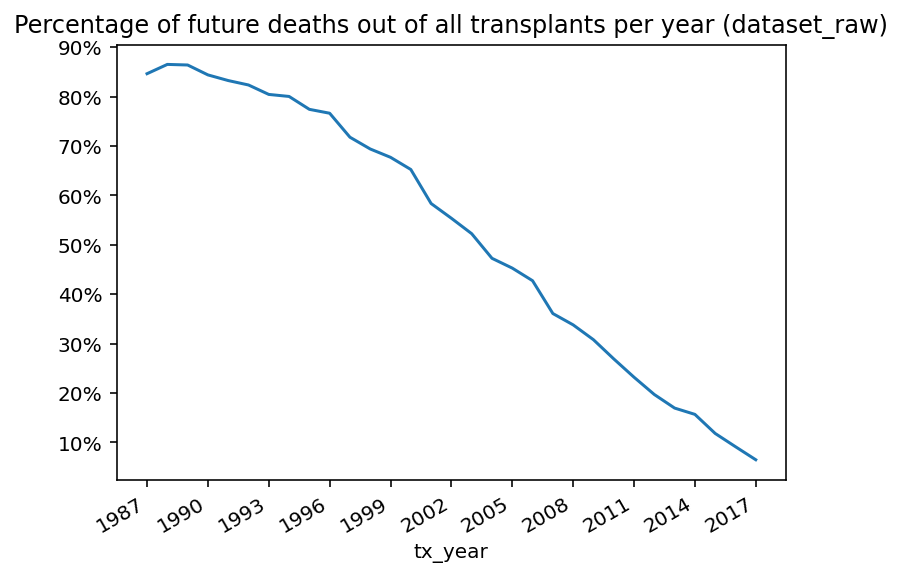

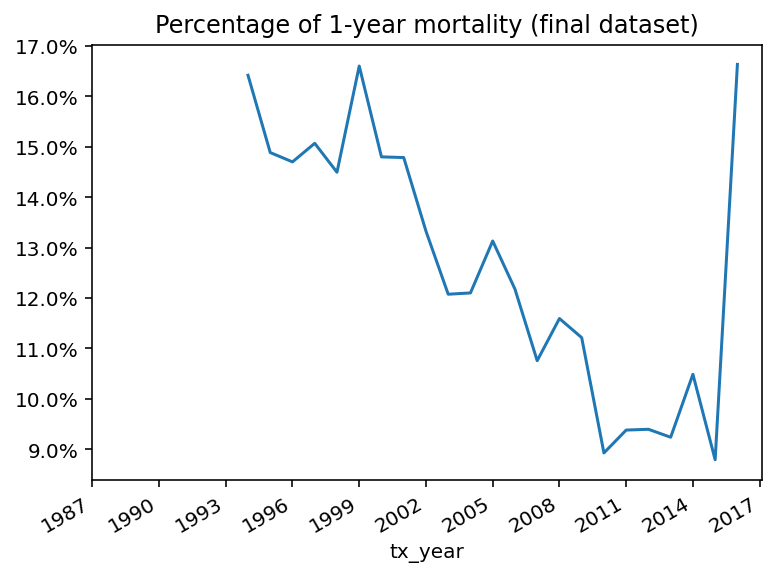

time: 316 ms (started: 2021-03-23 14:12:43 +01:00)


In [19]:
import matplotlib as mpl
from matplotlib import pyplot as plt

grouped = dataset_raw['death'].groupby(dataset_raw['tx_year'])
pyplot.title('Percentage of future deaths out of all transplants per year (dataset_raw)')
(grouped.sum() / grouped.count() * 100).plot()
plt.setp(pyplot.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks([
    *range(int(dataset_raw['tx_year'].min()), int(dataset_raw['tx_year'].max()), 3),
    int(dataset_raw['tx_year'].max())
])
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
pyplot.show()

grouped = y_365.groupby(dataset_raw['tx_year'])
pyplot.title('Percentage of 1-year mortality (final dataset)')
(grouped.sum() / grouped.count() * 100).plot()
plt.setp(pyplot.gca().get_xticklabels(), rotation=30, horizontalalignment='right')
plt.xticks([
    *range(int(dataset_raw['tx_year'].min()), int(dataset_raw['tx_year'].max()), 3),
    int(dataset_raw['tx_year'].max())
])
plt.gca().yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
pyplot.show()

## Features

> left: input
>
> ⬇
>
> center: preprocessed / omitted
>
> ⬇
>
> right: log / omitted

1. Thoracic diagnosis (thoracic_dgn)
2. Gender (gender)
3. Blood group (abo)
4. Recipient weight (wgt_kg_tcr)
5. hgt_cm_tcr
6. Intra-aortic balloon pump (iabp_tcr)
7. Inotropic Support (inotropes_tcr)
8. Functional status at listing recipient (func_stat_tcr)
9. Diabetes (diab)
10. Cerebrovascular disease (cereb_vasc)
11. Creatinine at listing (log_most_rcnt_creat)
12. Serum albumin (tot_serum_album)
13. sud_death
14. Defibrillator in recipient (impl_defibril)
15. Systolic pulmonary pressure recipient (mmHg) (hemo_sys_tcr)
16. Diastolic pulmonary pressure recipient (mmHg) (hemo_pa_dia_tcr)
17. Mean pulmonary pressure recipient (mmHg) (hemo_pa_mn_tcr)
18. Mean pulmonary wedge pressure recipient (mmHg) (hemo_pcw_tcr)
19. Cardiac output recipient (L/min) (hemo_co_tcr)
20. Cigarette use recipient (cig_use)
21. Prior cardiac surgery recipient (prior_card_surg_tcr)
22. Prior cardiac surgery recipient type (prior_card_surg_type_tcr)
23. Ethnicity (ethcat)
24. Ventilator Support at Listing (ven

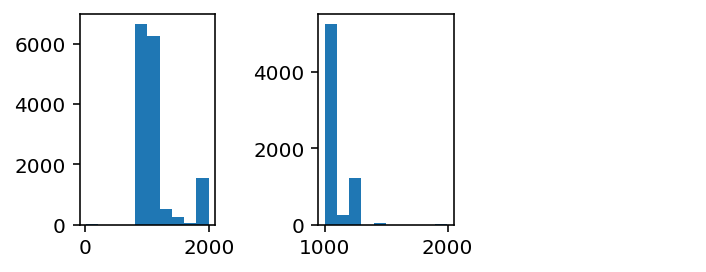

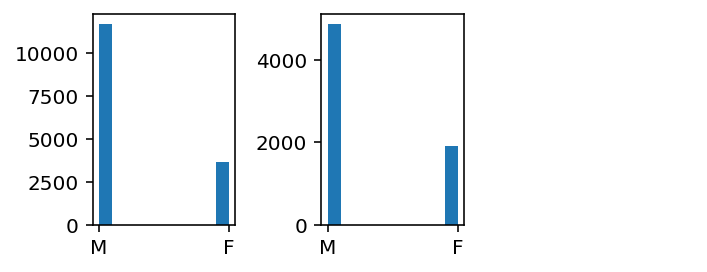

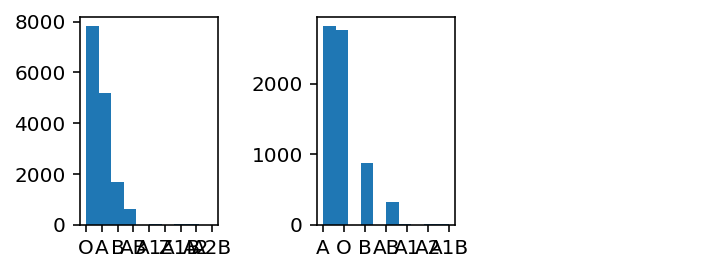

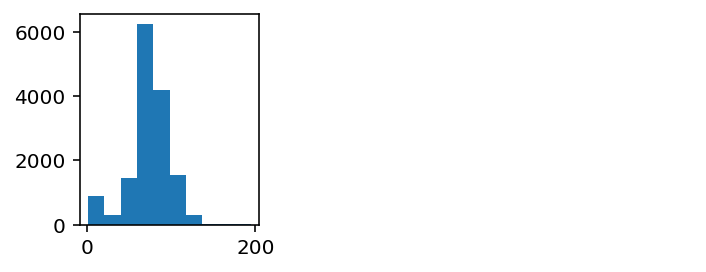

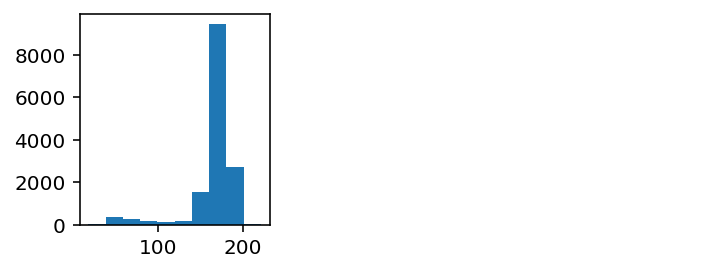

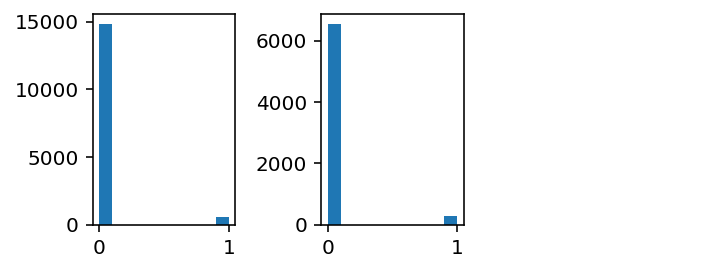

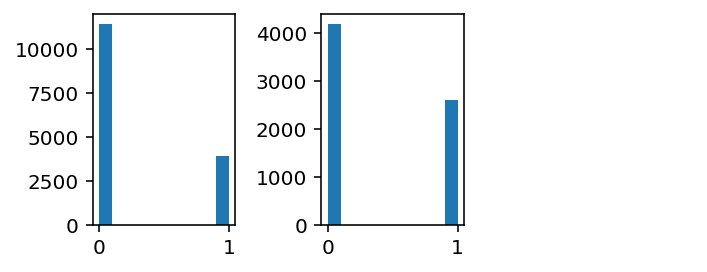

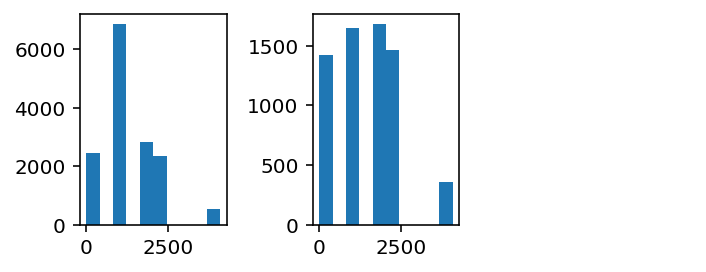

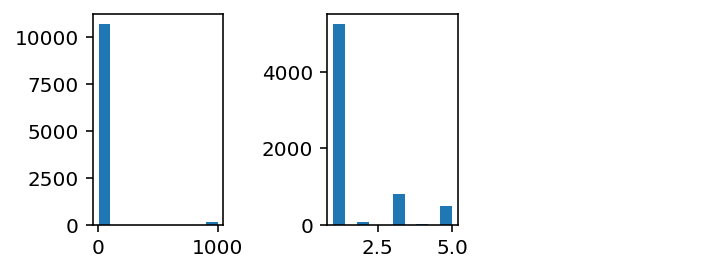

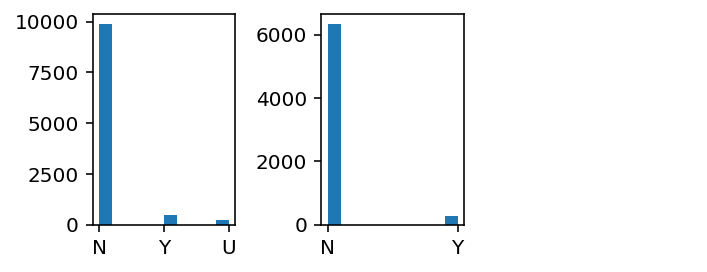

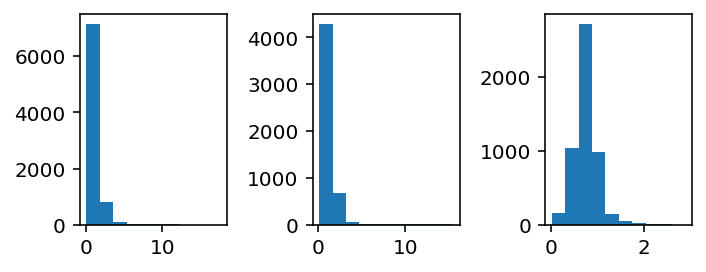

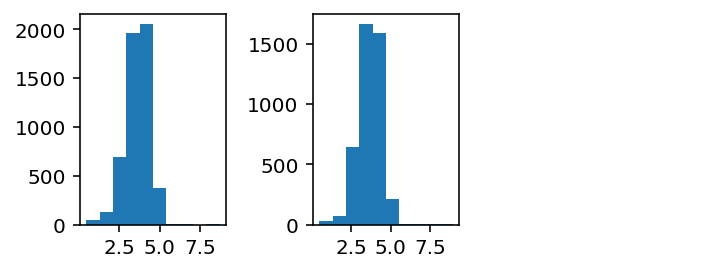

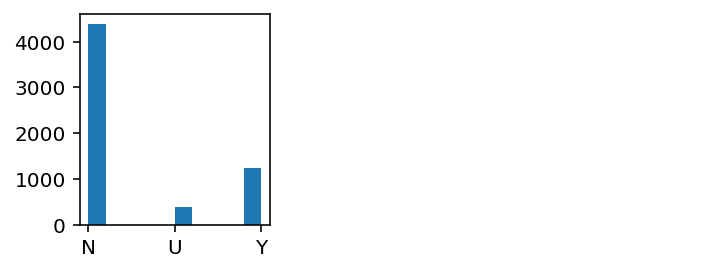

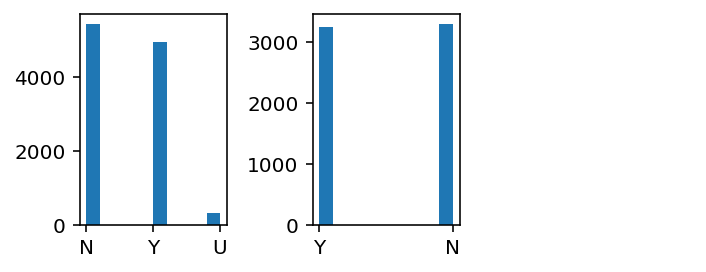

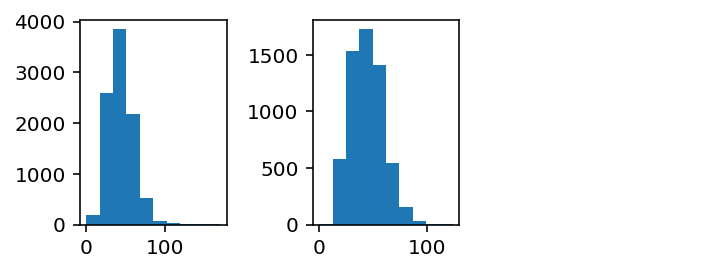

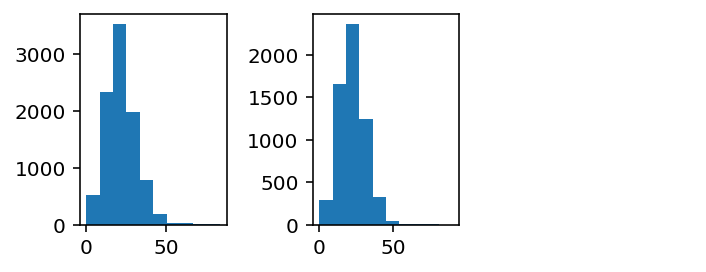

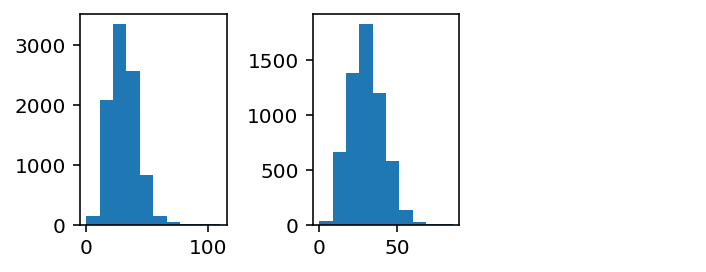

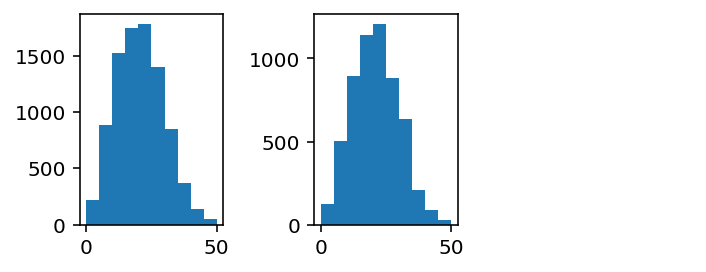

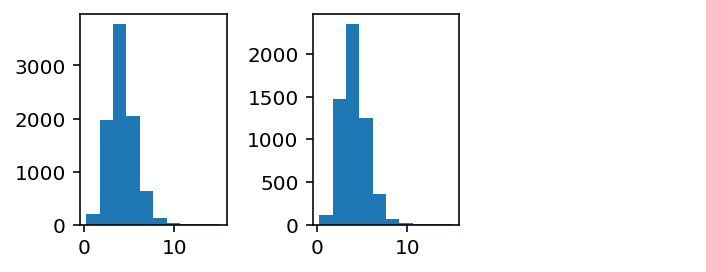

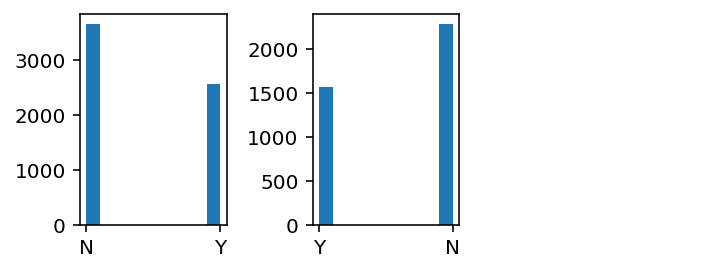

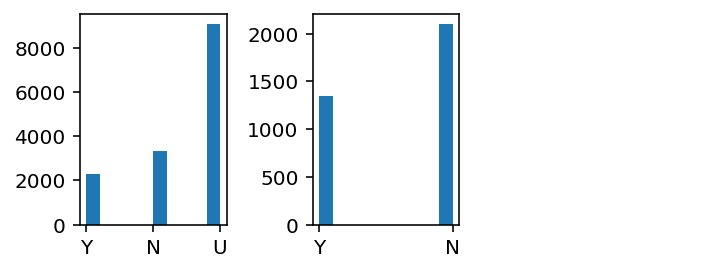

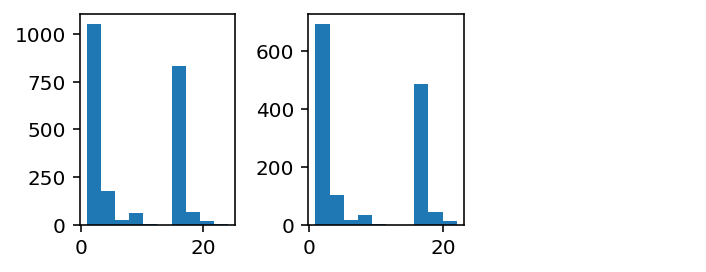

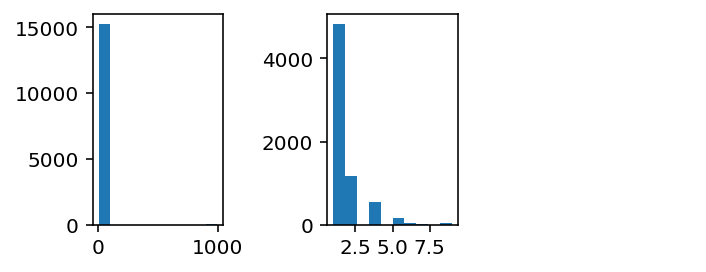

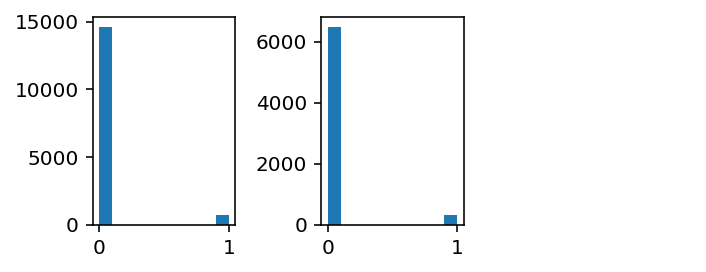

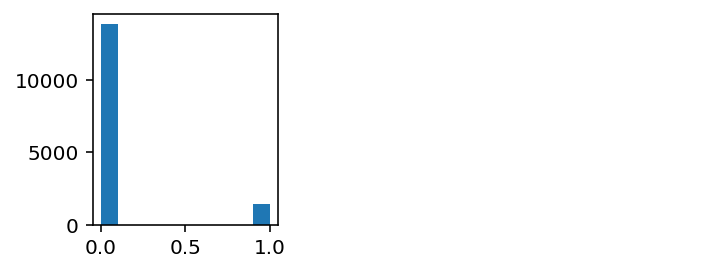

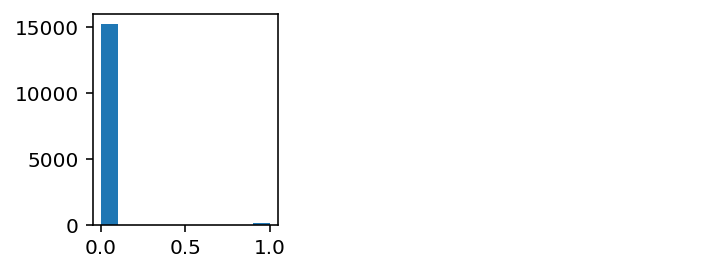

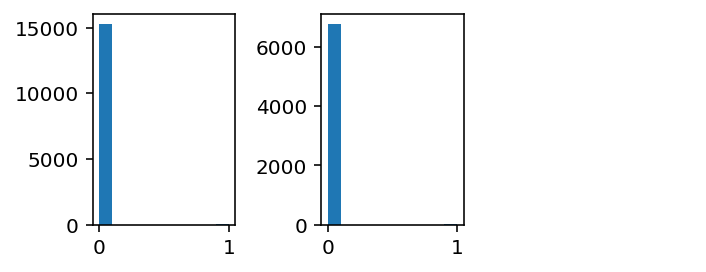

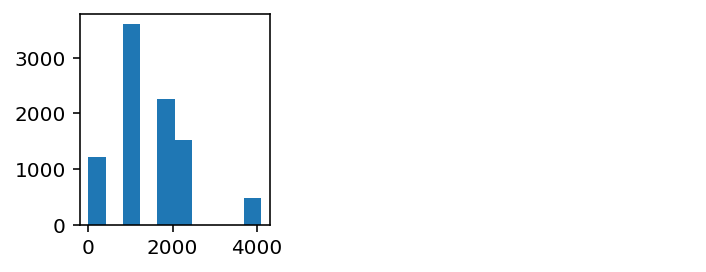

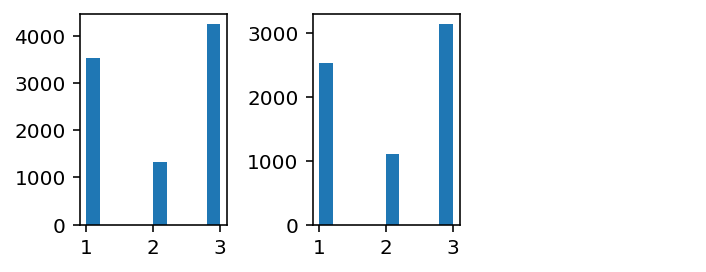

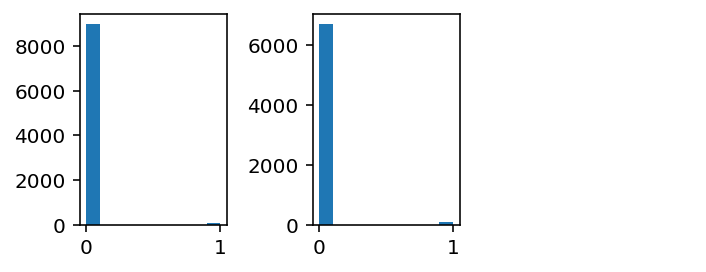

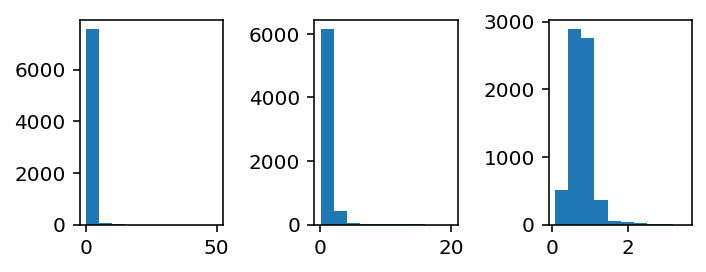

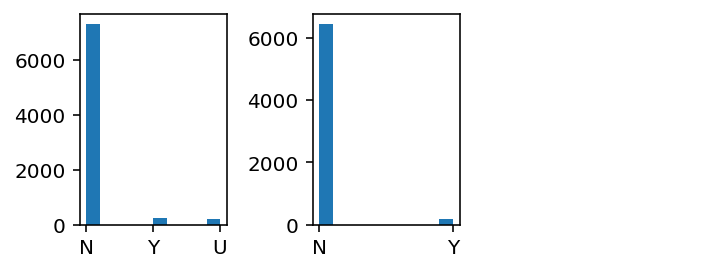

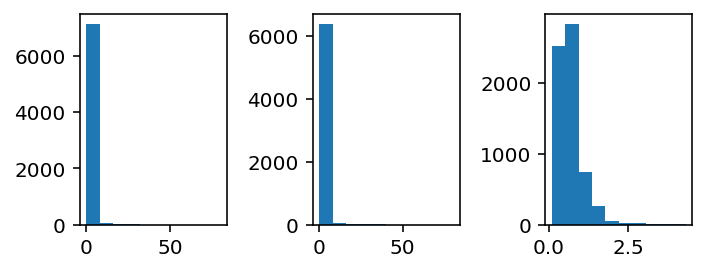

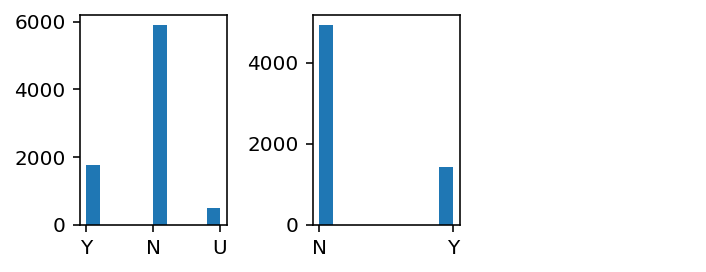

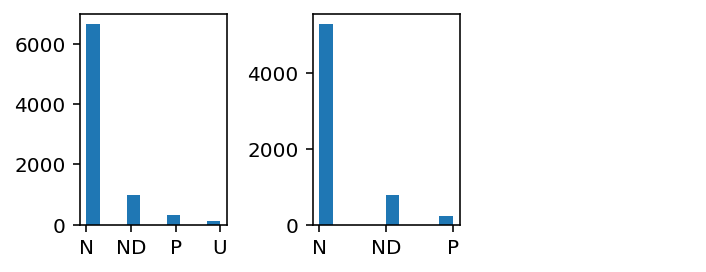

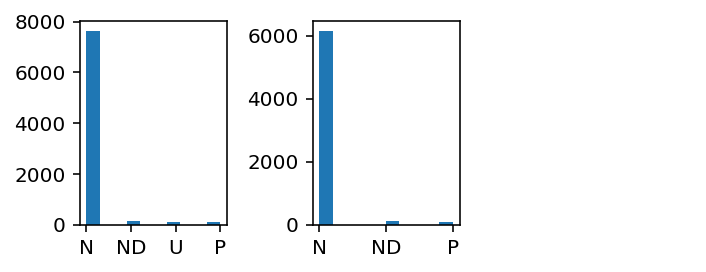

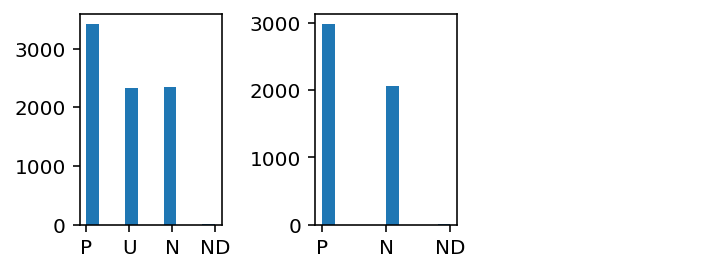

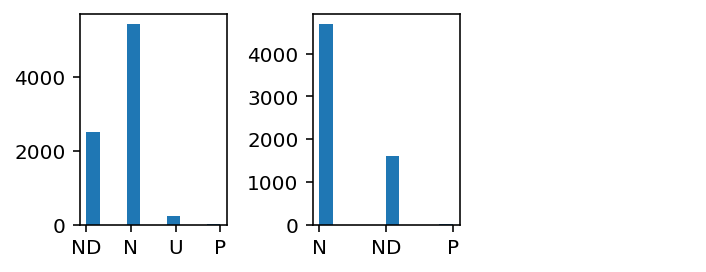

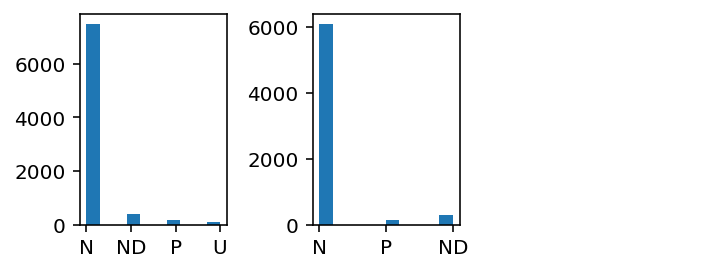

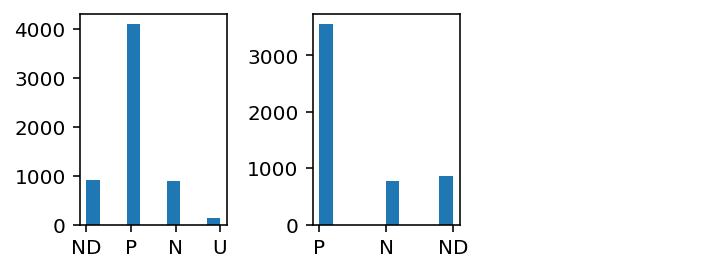

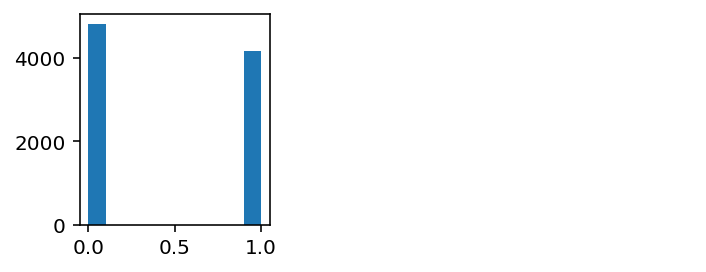

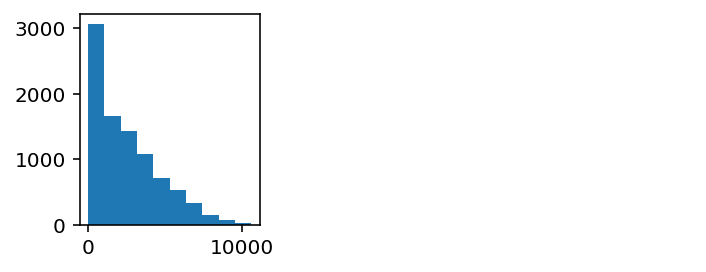

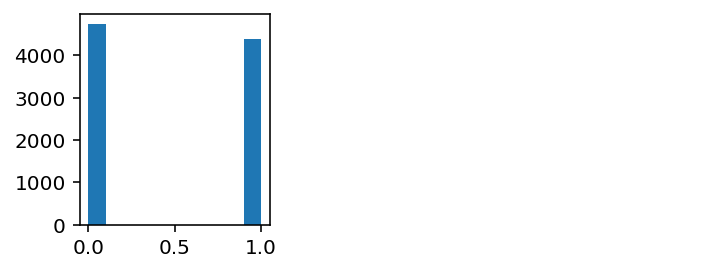

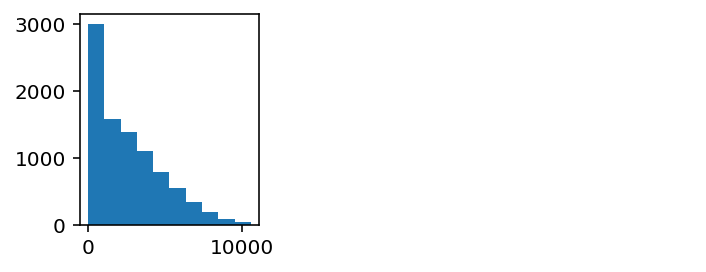

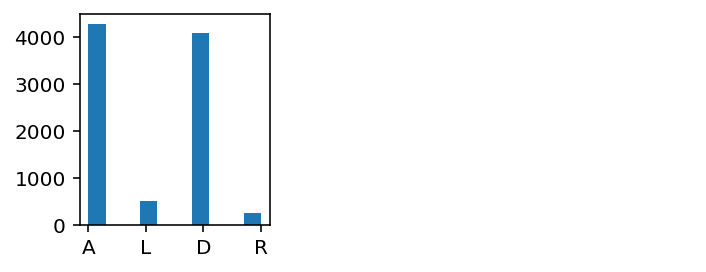

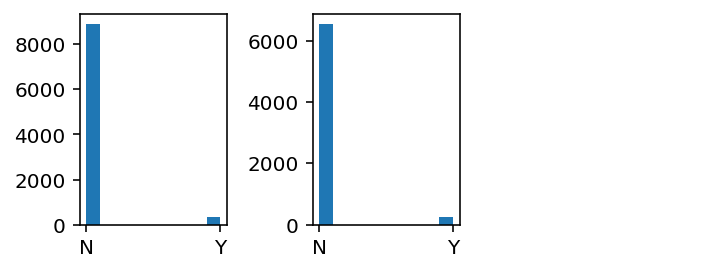

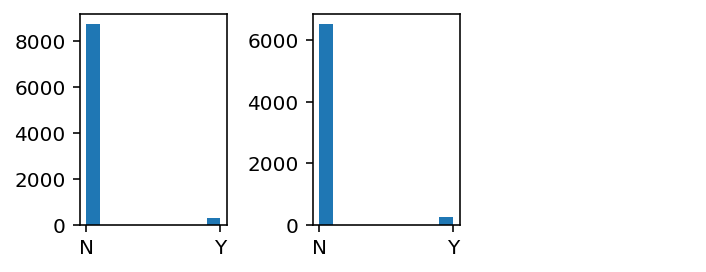

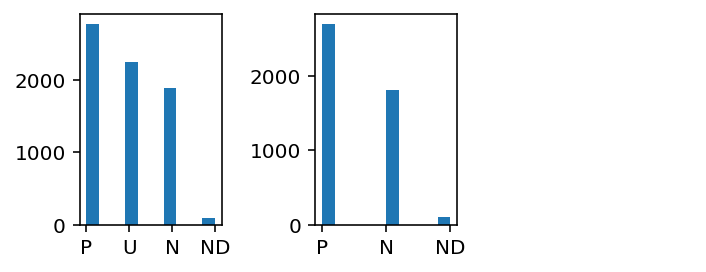

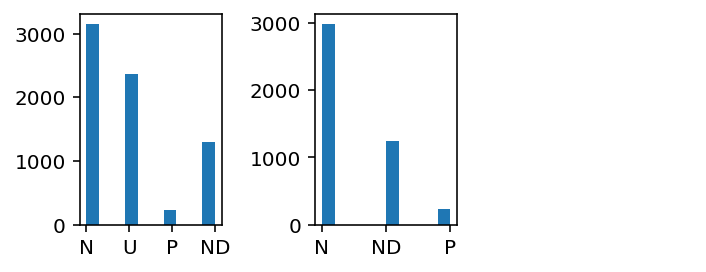

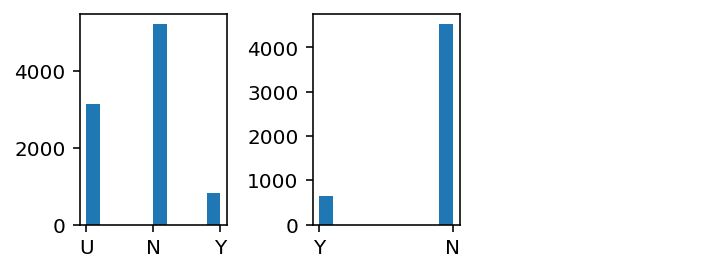

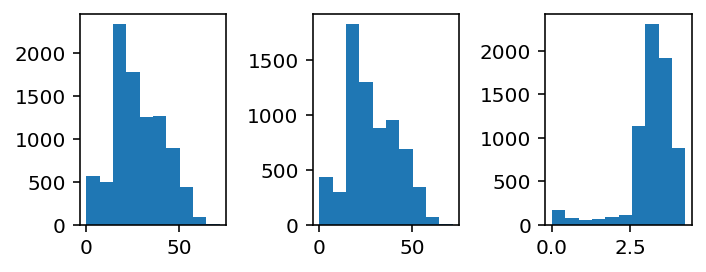

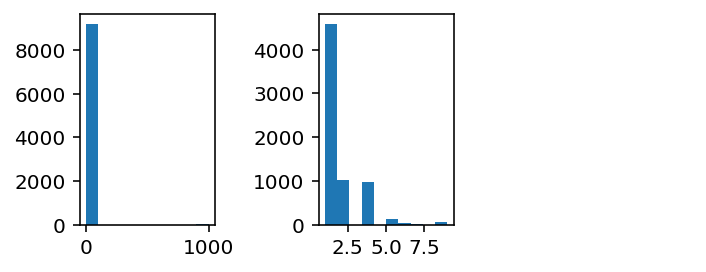

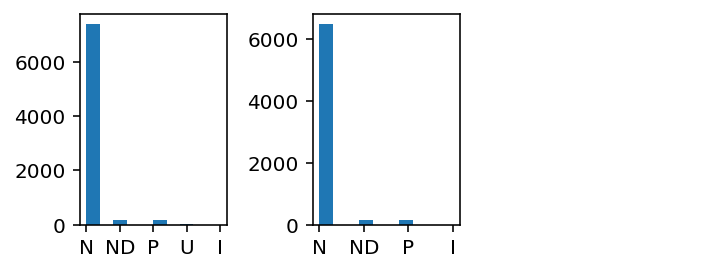

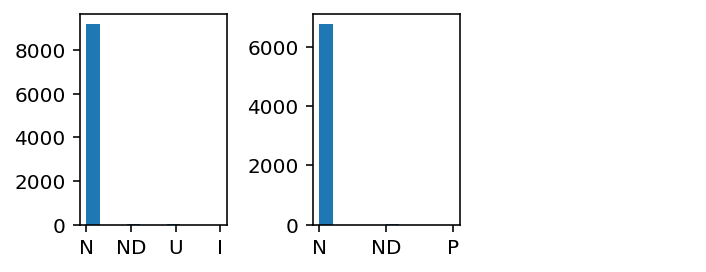

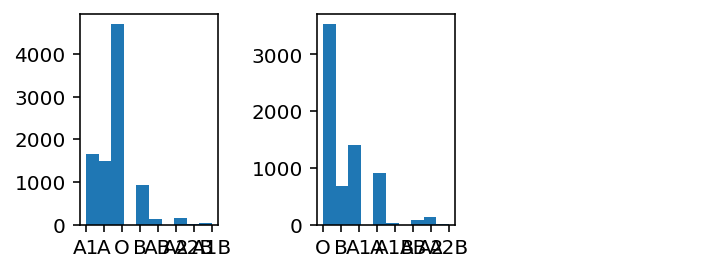

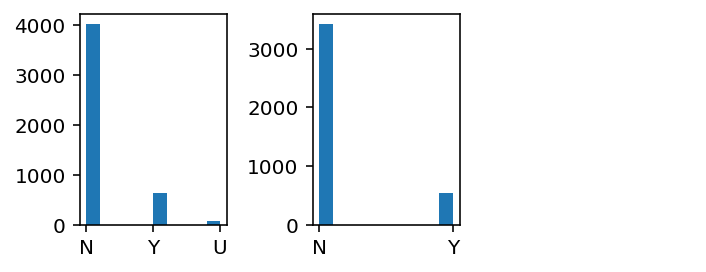

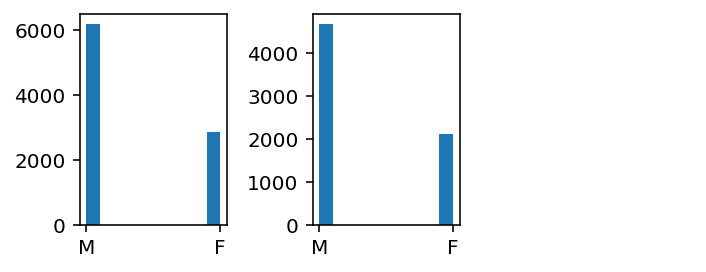

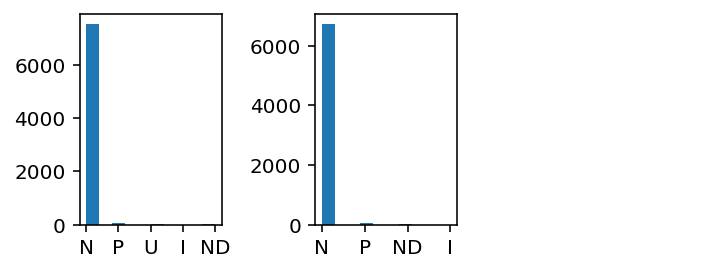

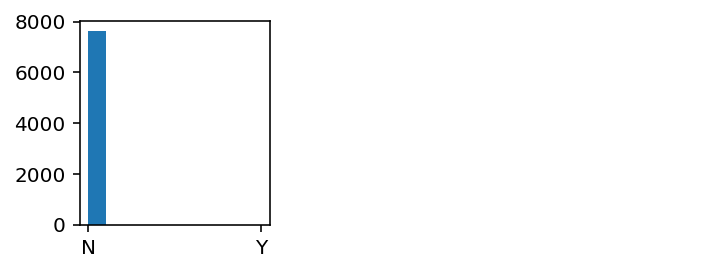

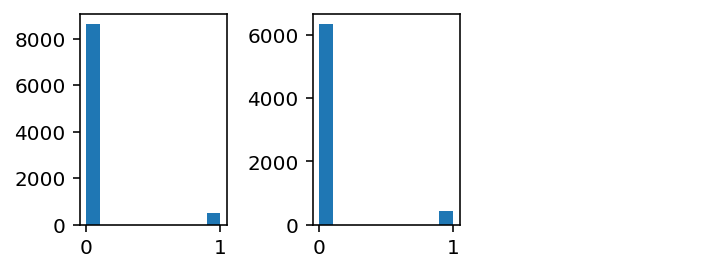

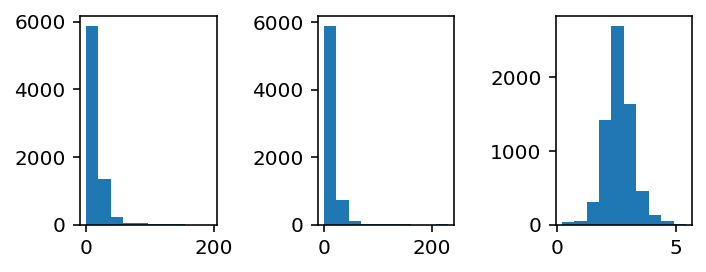

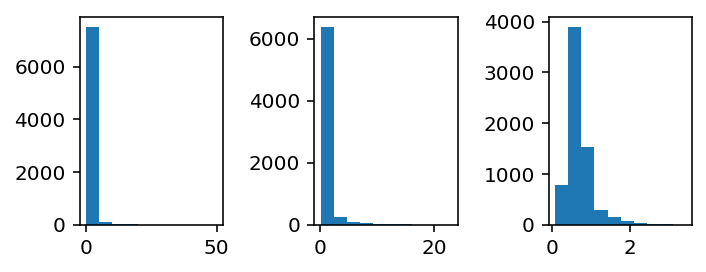

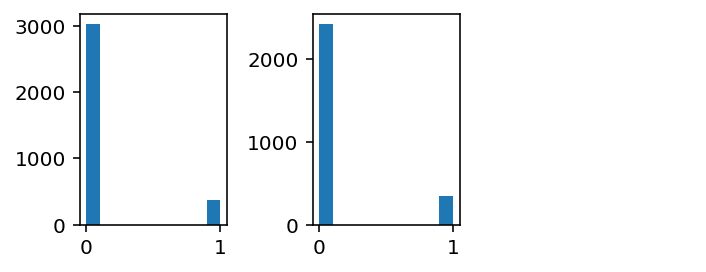

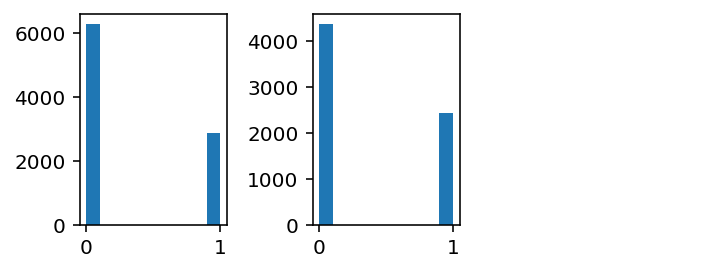

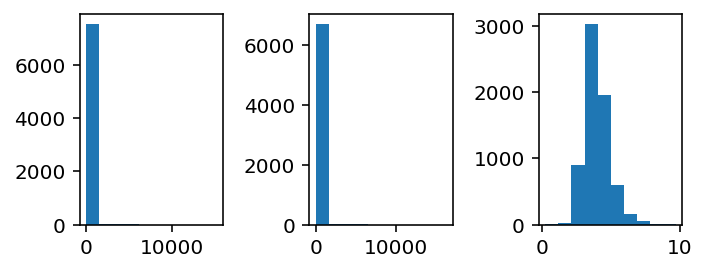

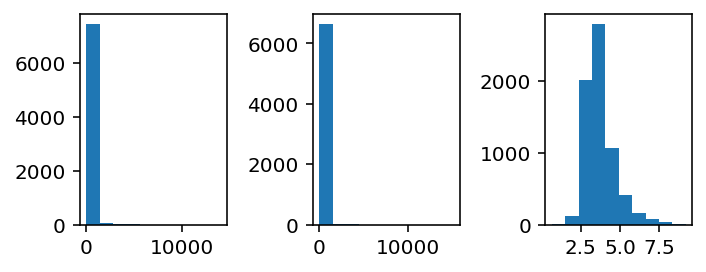

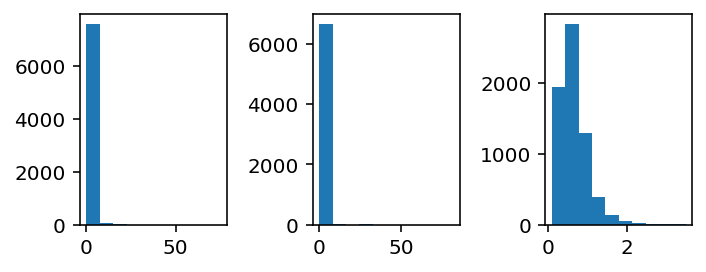

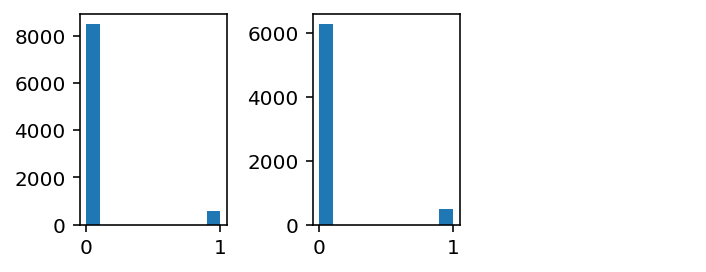

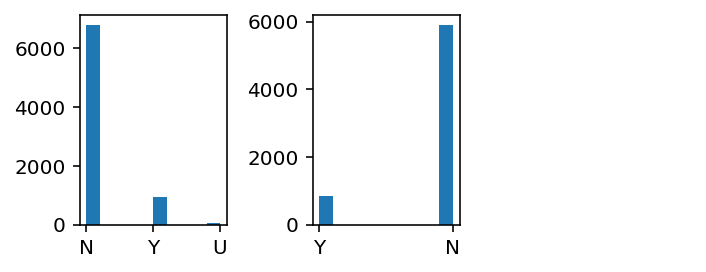

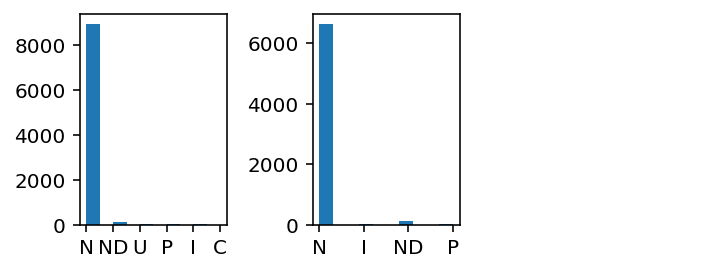

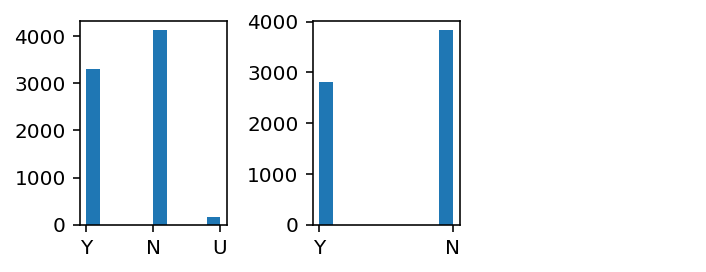

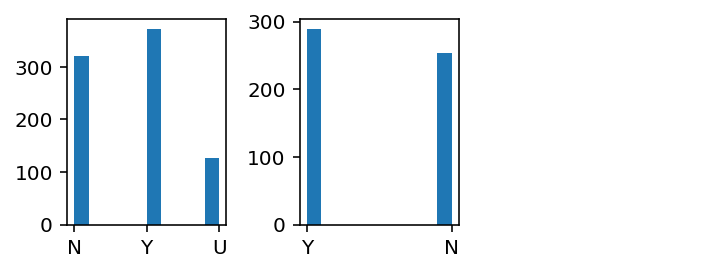

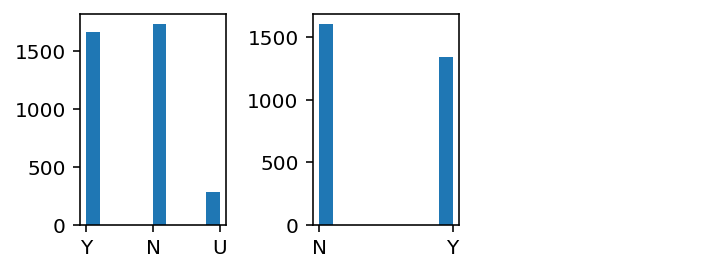

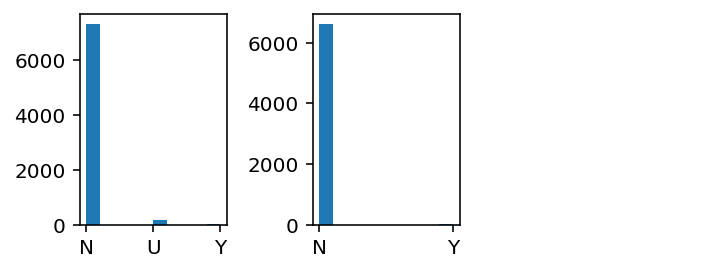

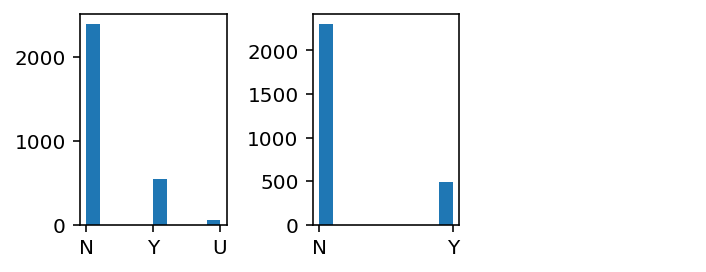

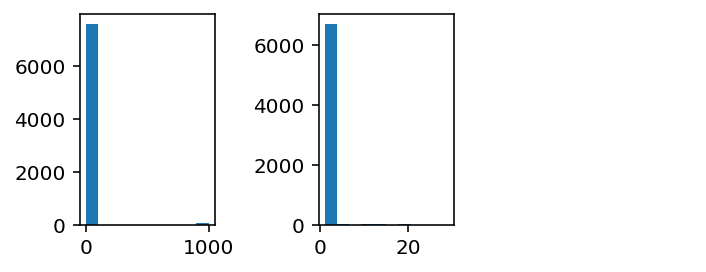

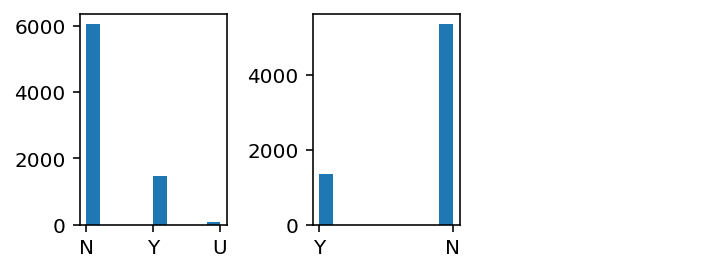

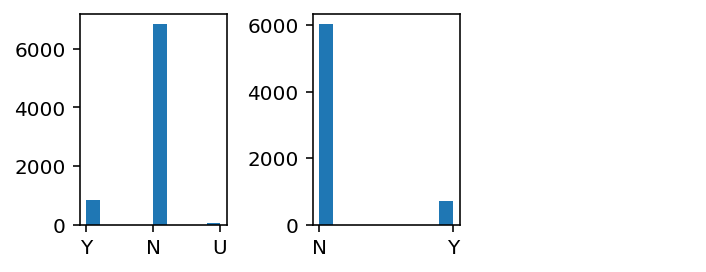

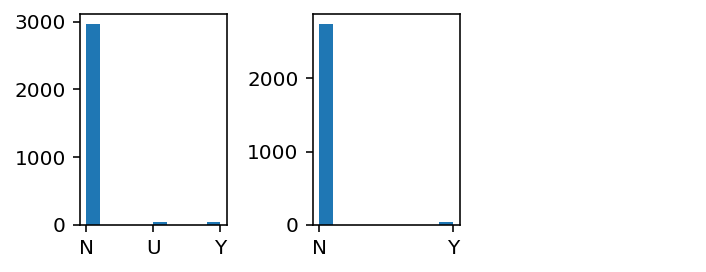

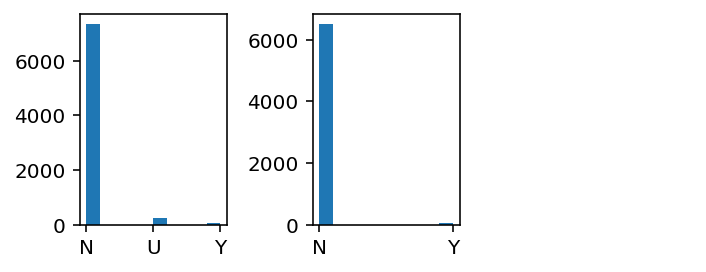

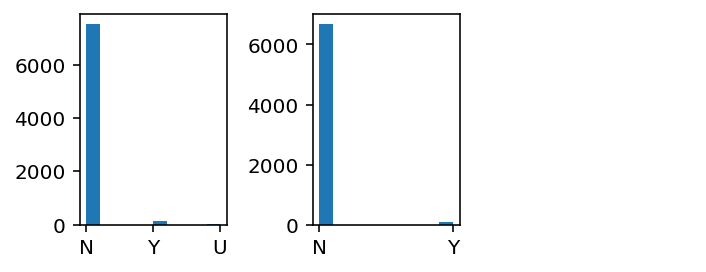

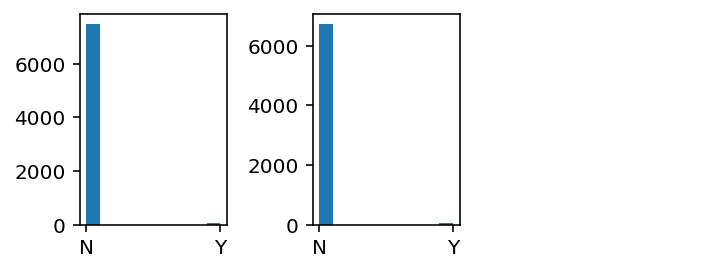

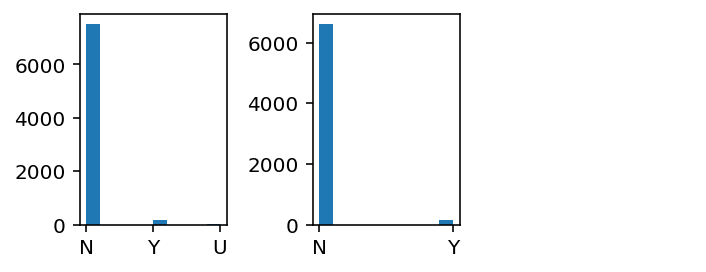

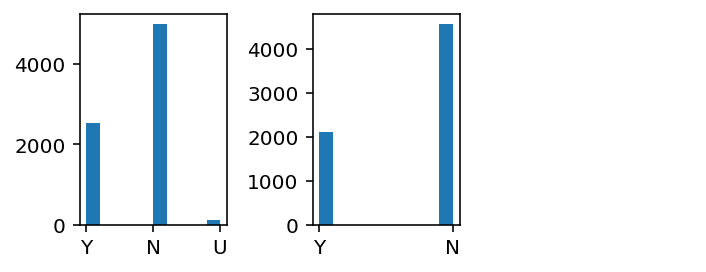

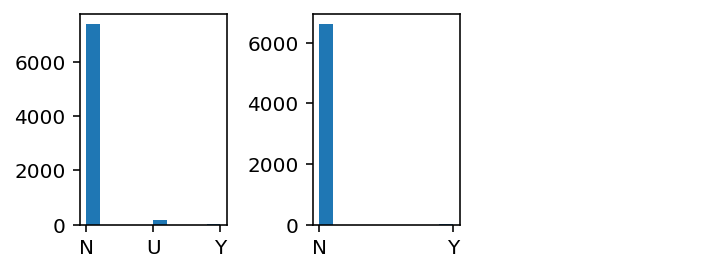

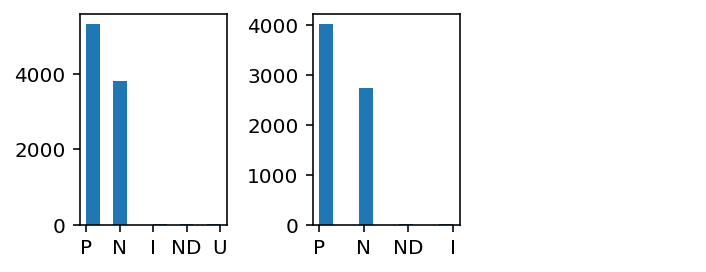

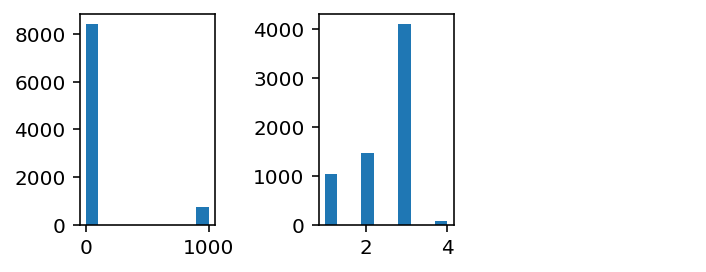

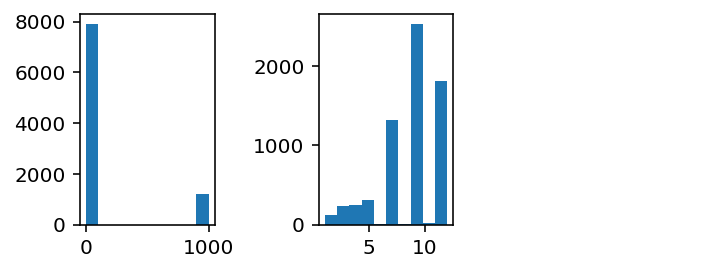

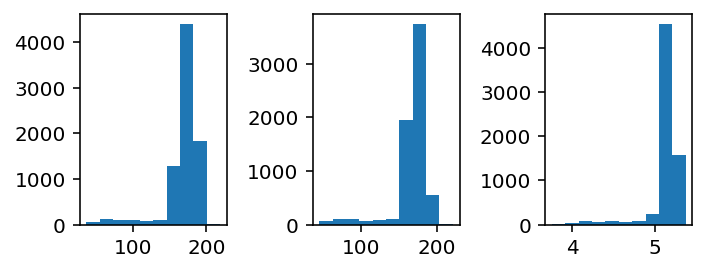

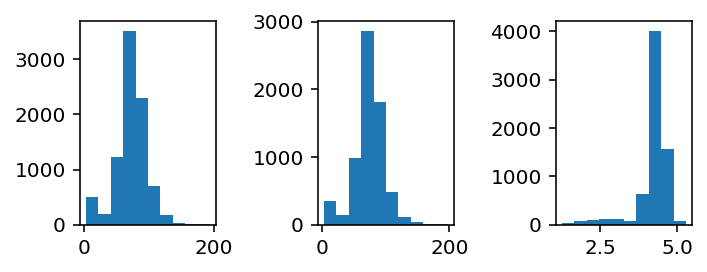

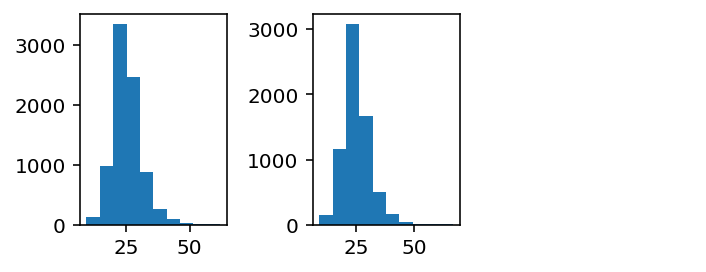

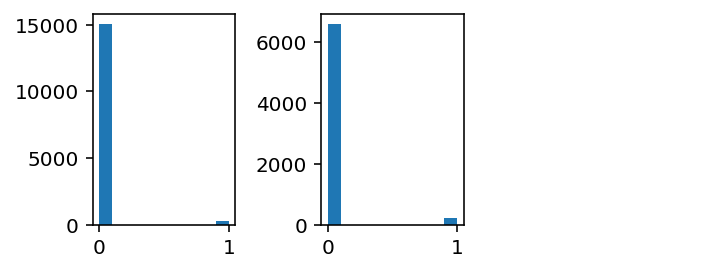

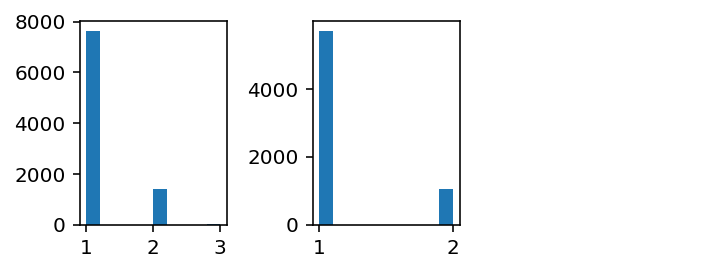

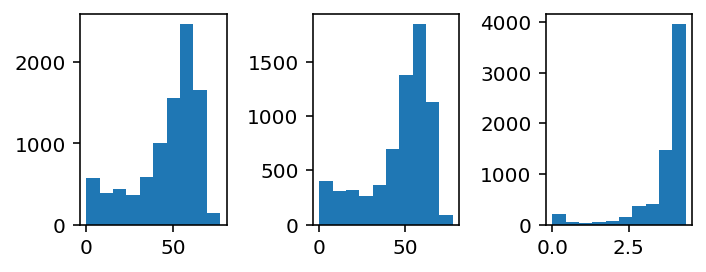

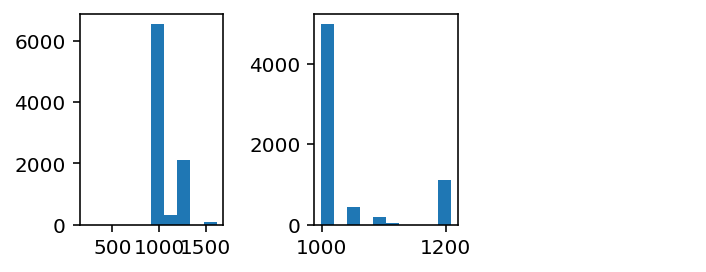

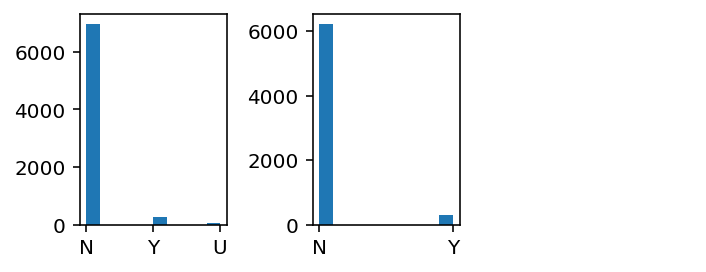

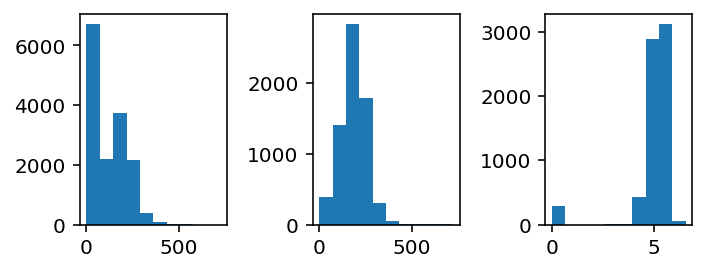

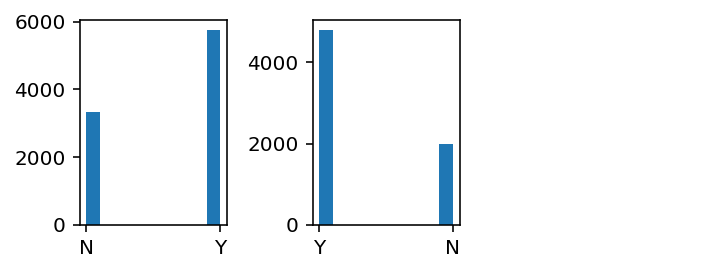

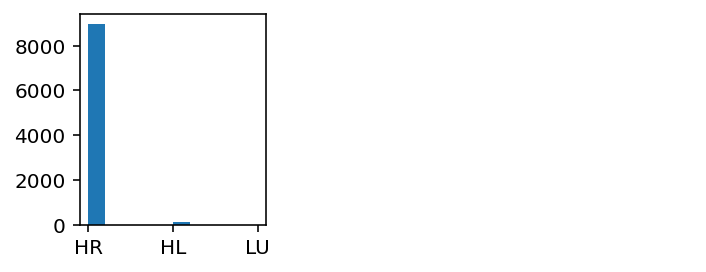

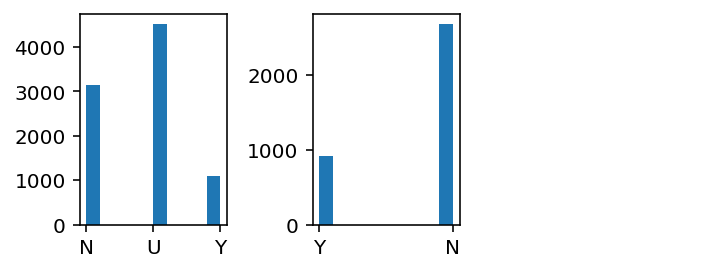

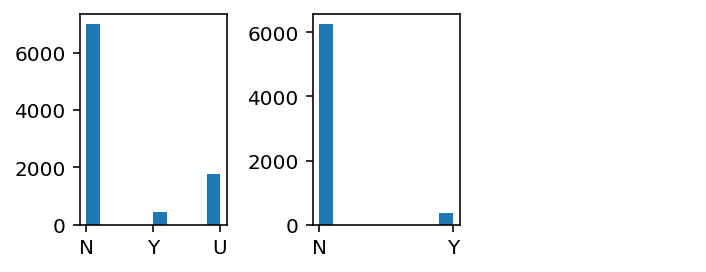

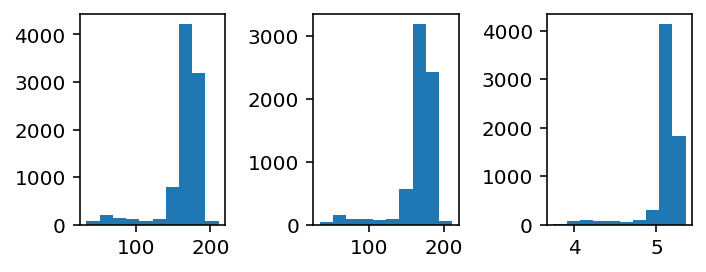

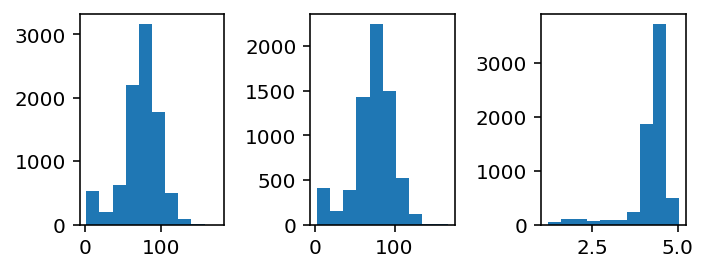

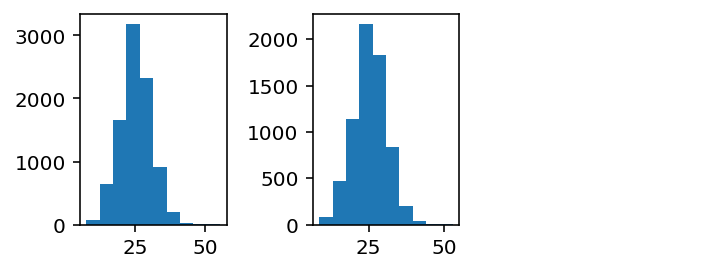

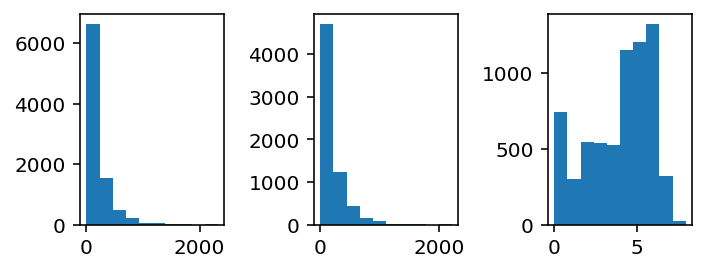

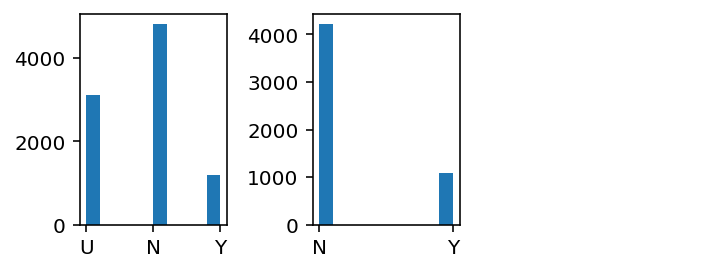

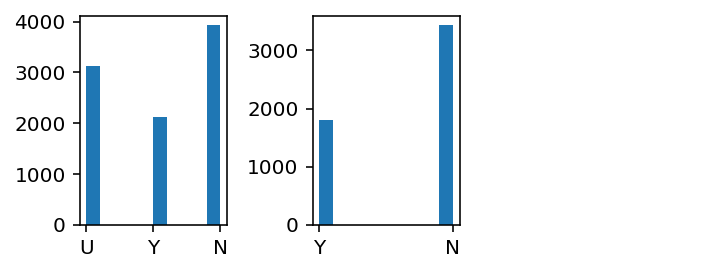

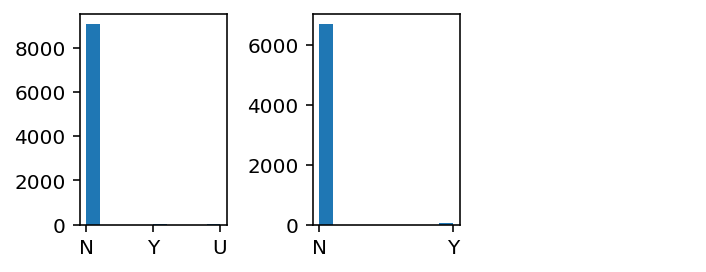

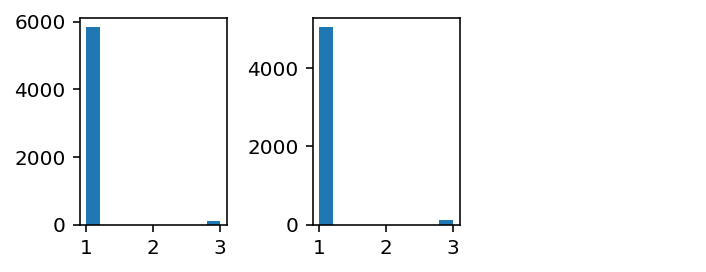

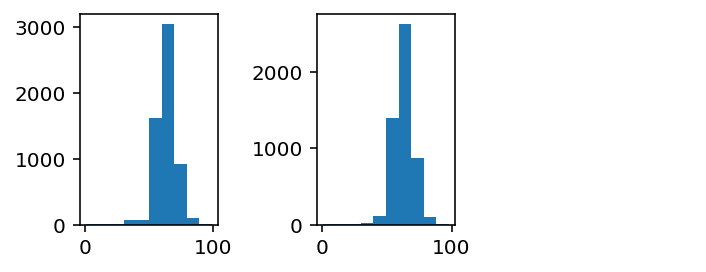

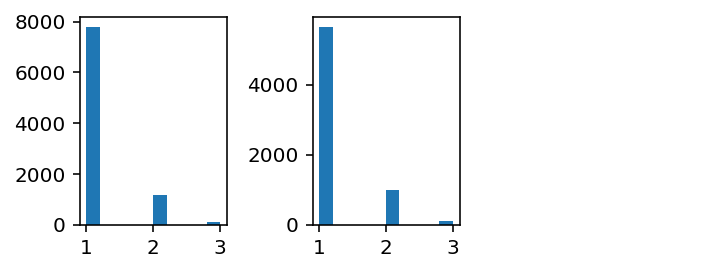

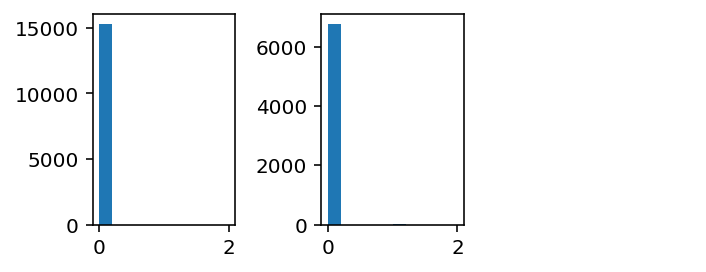

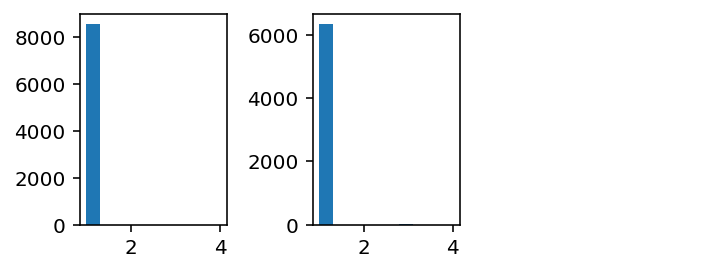

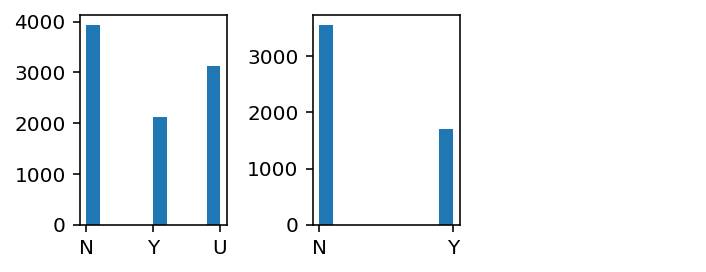

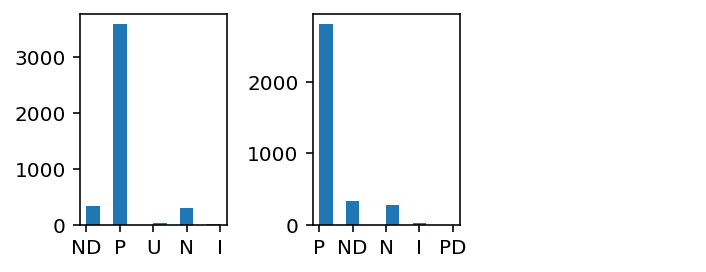

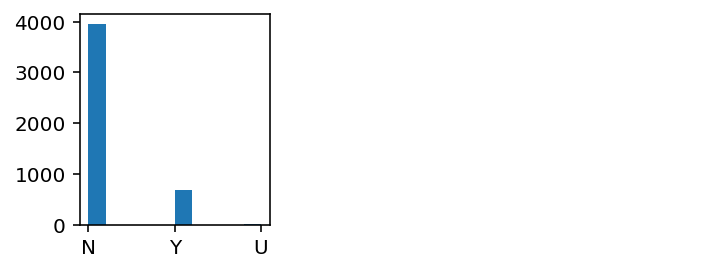

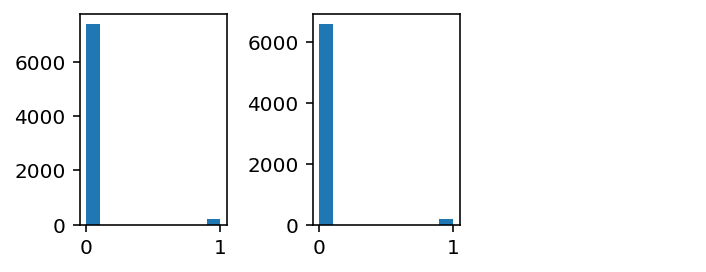

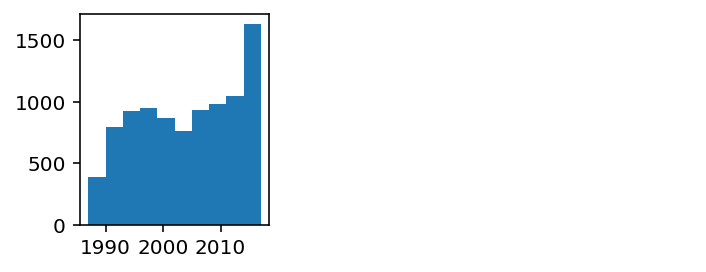

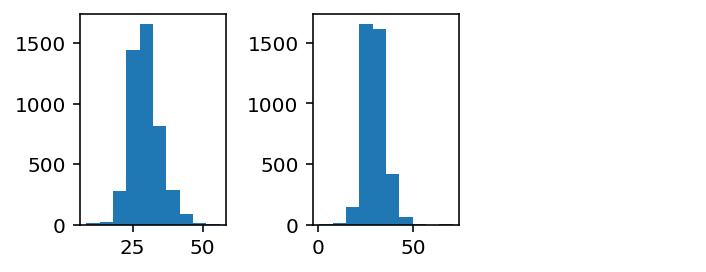

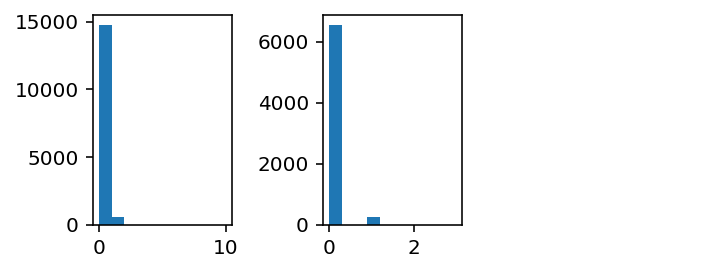

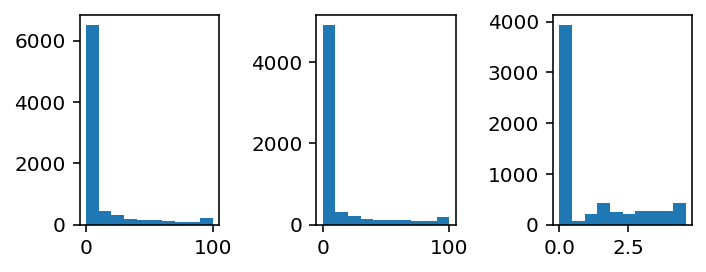

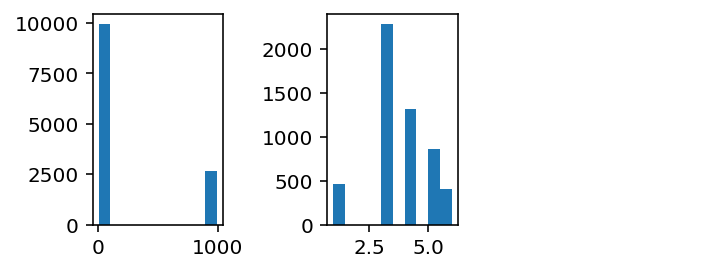

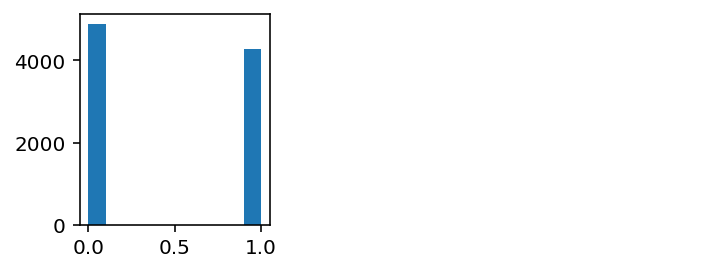

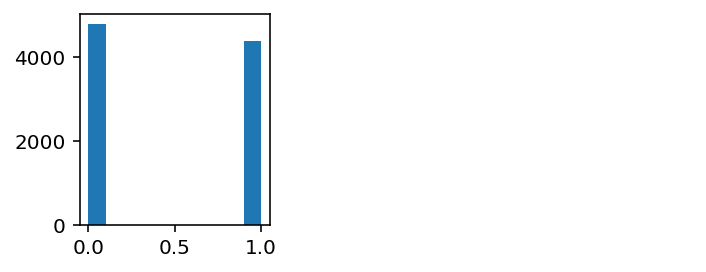

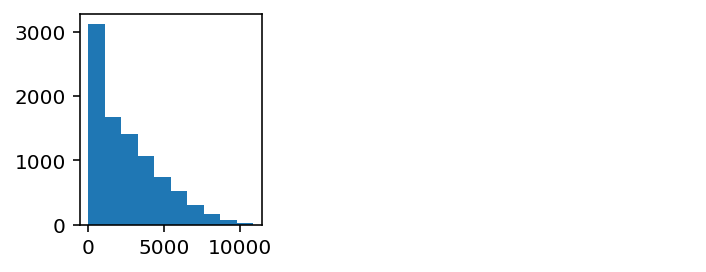

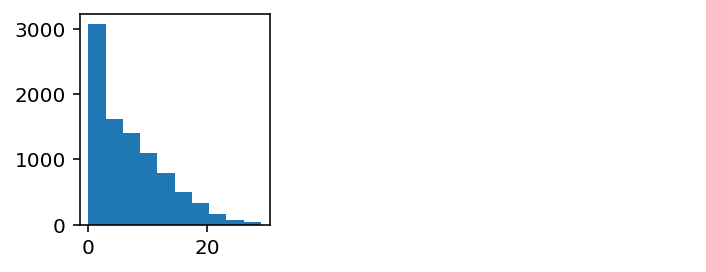

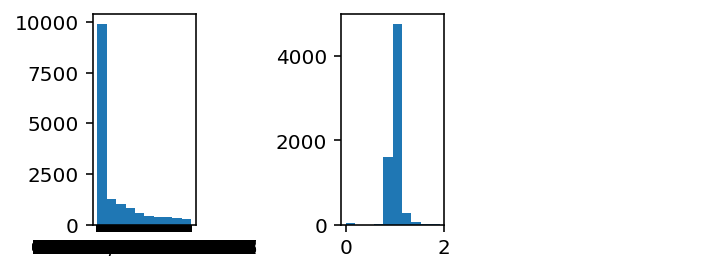

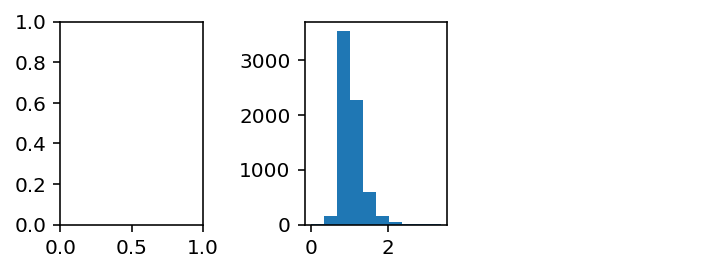

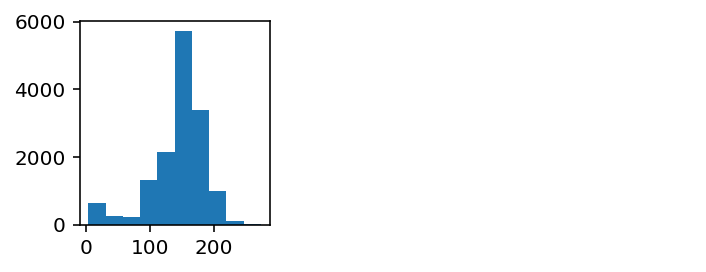

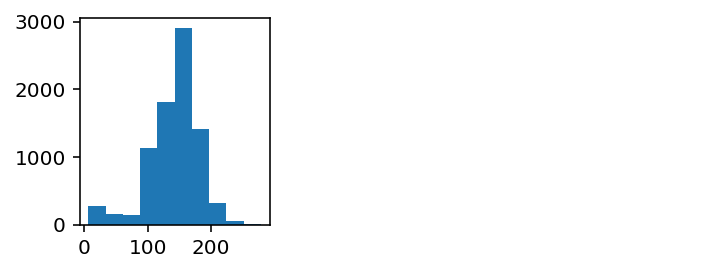

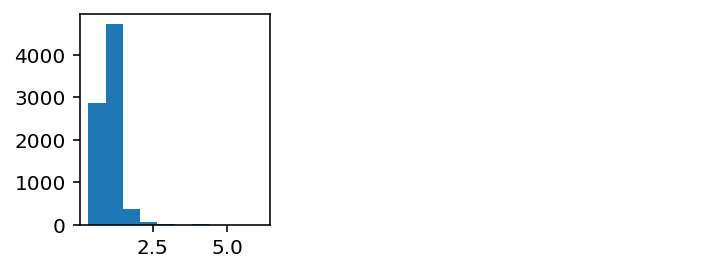

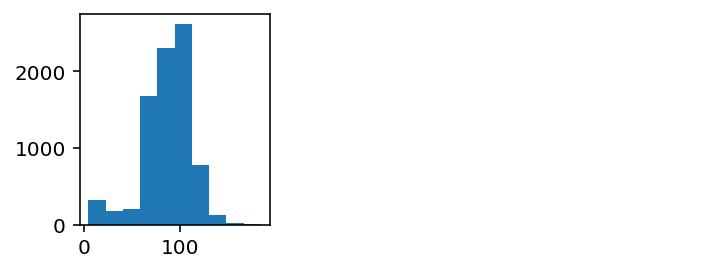

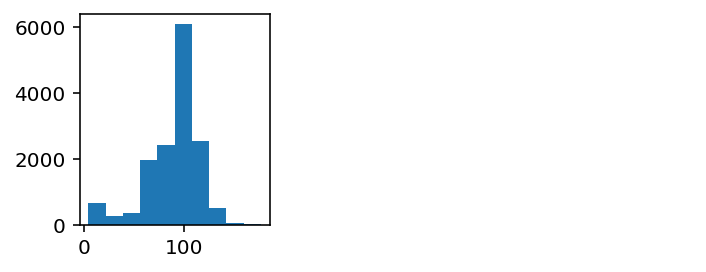

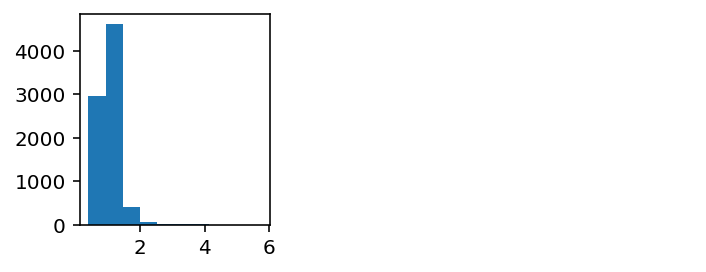

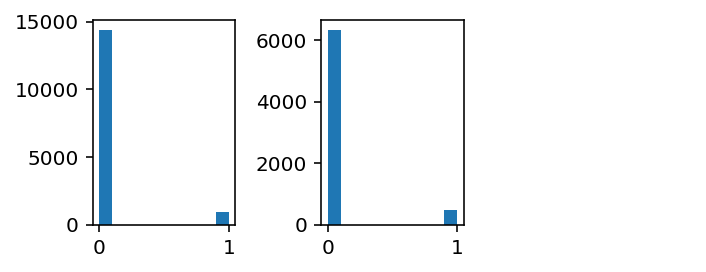

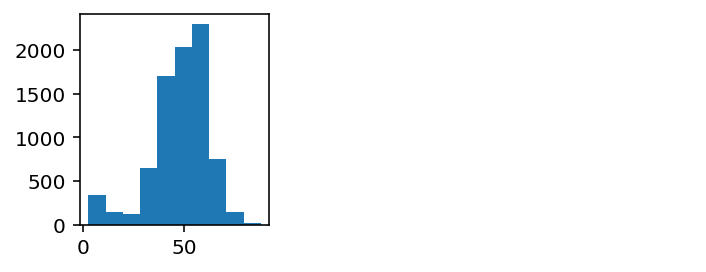

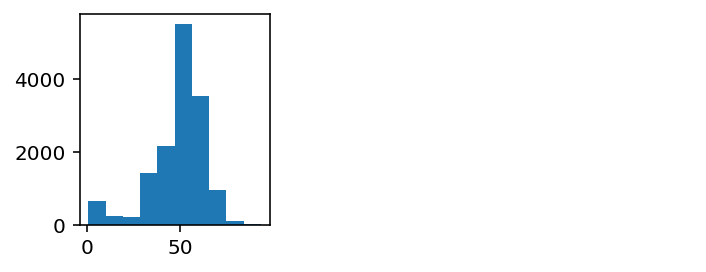

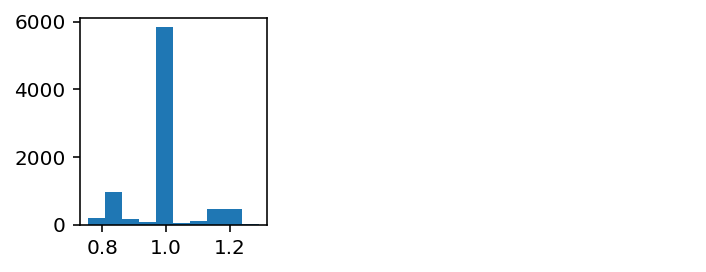

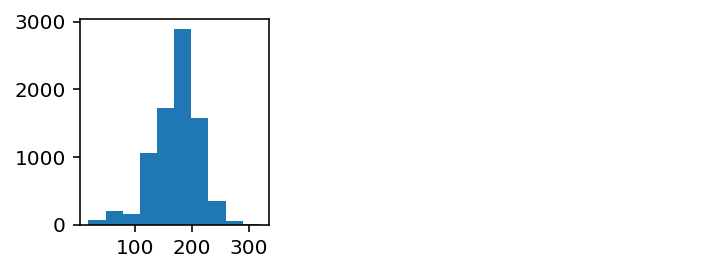

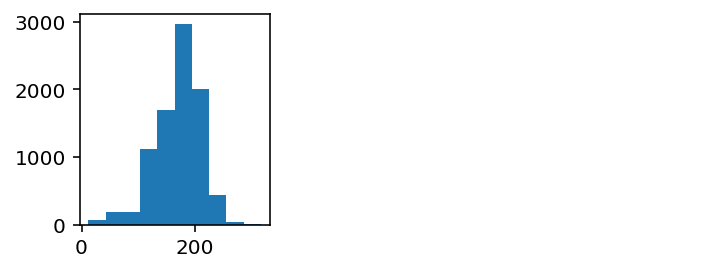

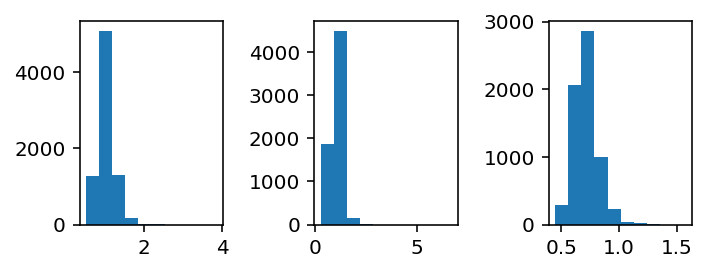

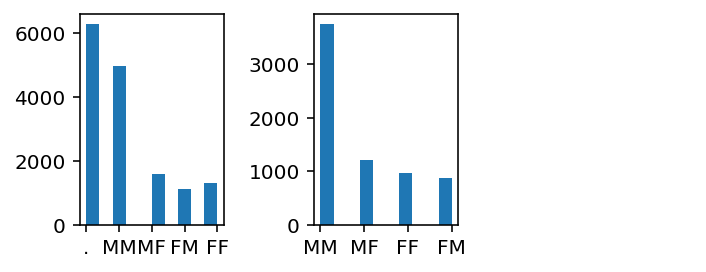

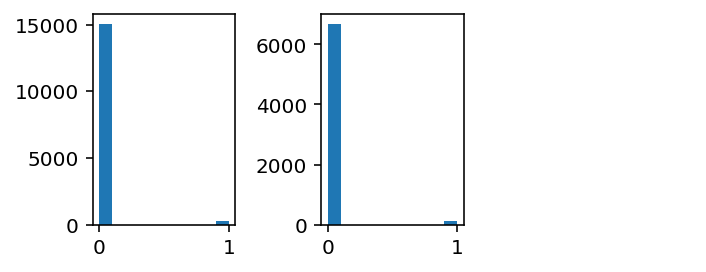

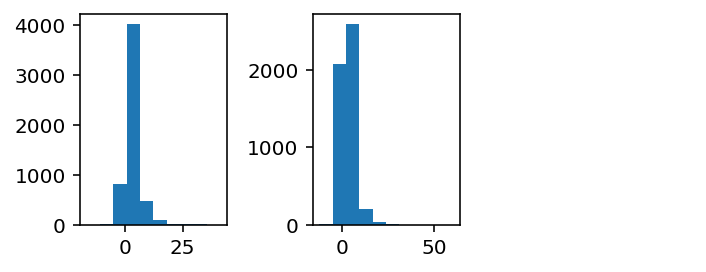

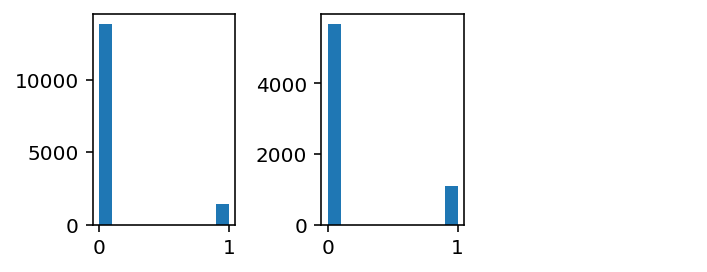

In [ ]:
from notebooks.heart_transplant.dependencies.heart_transplant_metadata import heart_transplant_metadata as metadata
from matplotlib import pyplot

X_365_reverse_log = reverse_log_transform_dataset(X_365)

for index, (feature_name, series) in enumerate(dataset_raw.items()):

    fig, ax = pyplot.subplots(1, 3, figsize=(5, 2))

    try:
        series.sample(frac=0.1).hist(grid=False, ax=ax[0])
    except Exception as e:
        print(e)

    log_feature_name = f'log_{feature_name}'

    try:
        X_365_reverse_log[feature_name]
    except KeyError:
        ax[1].axis("off")
    else:
        X_365_reverse_log[feature_name].loc[X_365.index].sample(frac=0.1).hist(
            grid=False, ax=ax[1]
        )

    try:
        X_365[log_feature_name]
    except KeyError:
        ax[2].axis("off")
    else:
        X_365[log_feature_name].loc[X_365.index].sample(frac=0.1).hist(
            grid=False, ax=ax[2]
        )

    metadata_item = metadata.get(feature_name)

    if log_feature_name in X_365:
        target_feature_name = log_feature_name
    else:
        target_feature_name = feature_name

    try:
        display_name = f'{metadata_item["name_long"]} ({target_feature_name})'
    except (KeyError, TypeError):
        display_name = f'{target_feature_name}'

    print(f'{index + 1}. {display_name}')
    fig.tight_layout()
    display(fig)
    pyplot.close()

print()